The dataset is from the following site: https://archive.ics.uci.edu/dataset/342/mice+protein+expression

## Imports

In [1]:
import copy
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from config import config
import os
import sys
current_dir = os.getcwd()
path='/home/eirik/projects/Interpretable-NNs'#'your/path/before/islbbnn/folder'
os.chdir(path)
sys.path.append('islbbnn')
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('islbbnn/networks')
from lrt_net import BayesianNetwork
import torch.nn.functional as F

os.chdir(current_dir) # set the working directory back to this one 

# Setup

## Device and config

In [2]:
# select the device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (torch.cuda.is_available()):
    print("GPUs are used!")
else:
    print("CPUs are used!")


# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
post_train_epochs = config['post_train_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
n_samples = config['n_samples']
lr = config['lr']
class_problem = config["class_problem"]
non_lin = config["non_lin"]
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
alpha_prior = config['inclusion_prob_prior']
std_prior = config['std_prior']
lower_init_lambda = config['lower_init_lambda']
upper_init_lambda = config['upper_init_lambda']
high_init_covariate_prob = config['high_init_covariate_prob']

GPUs are used!


## Data

In [3]:
X_train_original = np.loadtxt("data/X_train.txt", delimiter=",")
X_test_original = np.loadtxt("data/X_test.txt", delimiter=",")
y_train_original = np.loadtxt("data/Y_train.txt", delimiter=",")
y_test_original = np.loadtxt("data/Y_test.txt", delimiter=",")

# Include bias/intercept column into data
X_train_original = np.column_stack((np.ones(len(X_train_original)),X_train_original))
X_test_original = np.column_stack((np.ones(len(X_test_original)),X_test_original))

n,p = X_train_original.shape
print(n,p,dim)

# Train/test data as tensors
train_dat = torch.tensor(np.column_stack((X_train_original,y_train_original)),dtype = torch.float32)
test_dat = torch.tensor(np.column_stack((X_test_original,y_test_original)),dtype = torch.float32)

972 78 100


## Nr of classes and batch size

In [4]:
if class_problem:
    n_classes = len(np.unique(y_train_original))
    multiclass = n_classes > 1
else: 
    n_classes = 1  # Just need to set it to something above zero
    multiclass = False

BATCH_SIZE = int((n)/27)
# TEST_BATCH_SIZE = int(n*0.10) # Would normally call this the "validation" part (will be used during training)
# VAL_BATCH_SIZE = int(n*0.10) # and this the "test" part (will be used after training)

TRAIN_SIZE = int((n))


NUM_BATCHES = TRAIN_SIZE/BATCH_SIZE

print(NUM_BATCHES)


27.0


# Train and test model

In [ ]:
tot_rounds = epochs + post_train_epochs

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    net = BayesianNetwork(
        dim, 
        p, 
        HIDDEN_LAYERS, 
        classification=class_problem, 
        a_prior=alpha_prior, 
        std_prior=std_prior, 
        n_classes=n_classes,
        act_func=F.relu,
        lower_init_lambda=lower_init_lambda,
        upper_init_lambda=upper_init_lambda,
        high_init_covariate_prob=high_init_covariate_prob).to(DEVICE)
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    scheduler = MultiStepLR(optimizer, milestones=[int(0.3*tot_rounds), int(0.5*tot_rounds), int(0.7*tot_rounds), int(0.9*tot_rounds)], gamma=0.5)

    all_nll = []
    all_loss = []
            
    train_dat = torch.tensor(np.column_stack((X_train_original,y_train_original)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(tot_rounds):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train, multiclass=multiclass)
        nll_val, loss_val, ensemble_val = pip_func.val(net, test_dat, DEVICE, verbose=verbose, reg=(not class_problem), multiclass=multiclass)
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break

        scheduler.step()
        
    if save_res:
        torch.save(net, f"network/net{ni}")
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni], test_dat, DEVICE, SAMPLES=100, CLASSES=n_classes, reg=(not class_problem), multiclass=multiclass) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)
    pf.run_path_graph(all_nets[ni], threshold=0.5, save_path=f"path_graphs/prob/net{ni}_relu")
    pf.run_path_graph_weight(net, save_path=f"path_graphs/weight/net{ni}_relu", show=False)


if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

print("Results full model:")
print(m)
print("\n\nResults median prob model:")
print(m_median)

if save_res:
    # m = np.array(metrics_several_runs)
    np.savetxt(f'results/lrt_class_skip_{HIDDEN_LAYERS}_hidden_{dim}_dim_{epochs}_epochs_{lr}_lr_mice_protein_relu_full.txt',m,delimiter = ',')
    # m_median = np.array(metrics_median_several_runs)
    np.savetxt(f'results/lrt_class_skip_{HIDDEN_LAYERS}_hidden_{dim}_dim_{epochs}_epochs_{lr}_lr_mice_protein_relu_median.txt',m_median,delimiter = ',')

## Results

Output from model (removed for readability)

* Median probability model:
    * Acc: 100\%
    * Used weights (in active paths): 288 (did not converge before termination $\rightarrow$ potential for sparser model)
    * Density: 0.011 (27'024 inital weights)
* Full model:
    * Acc: 100\%

## Path graphs

All active paths in median probability model (MPM)

### Probability

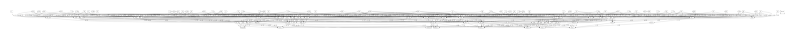

In [6]:
img = mpimg.imread("path_graphs/prob/net0_relu.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

### Weight

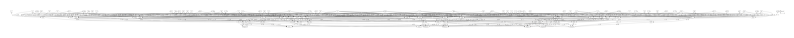

In [7]:
img = mpimg.imread("path_graphs/weight/net0_relu.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

## Individual class paths

In [9]:
net = torch.load('network/net0', weights_only=False).to("cpu")
pf.plot_path_individual_classes(net, n_classes)

Used weights:  160
Used weights:  132
Used weights:  156
Used weights:  135
Used weights:  153
Used weights:  74
Used weights:  146
Used weights:  133


# Explanations

In [10]:
class_names = ["c-CS-m", "c-CS-s", "c-SC-m", "c-SC-s", "t-CS-m", "t-CS-s", "t-SC-m", "t-SC-s"]

## Global explain

In [11]:
data = torch.tensor(X_train_original,dtype = torch.float32)
num_samp = 10
contributions_lin = np.zeros((len(X_train_original), num_samp, p, n_classes))

for ind, d in enumerate(data):
    expl, _, _ = pip_func.local_explain_piecewise_linear_act(net, d, n_classes=n_classes, n_samples=num_samp, include_potential_contribution=False)
    for c in range(n_classes):
        contributions_lin[ind,:,:,c] = expl[:,:,c]

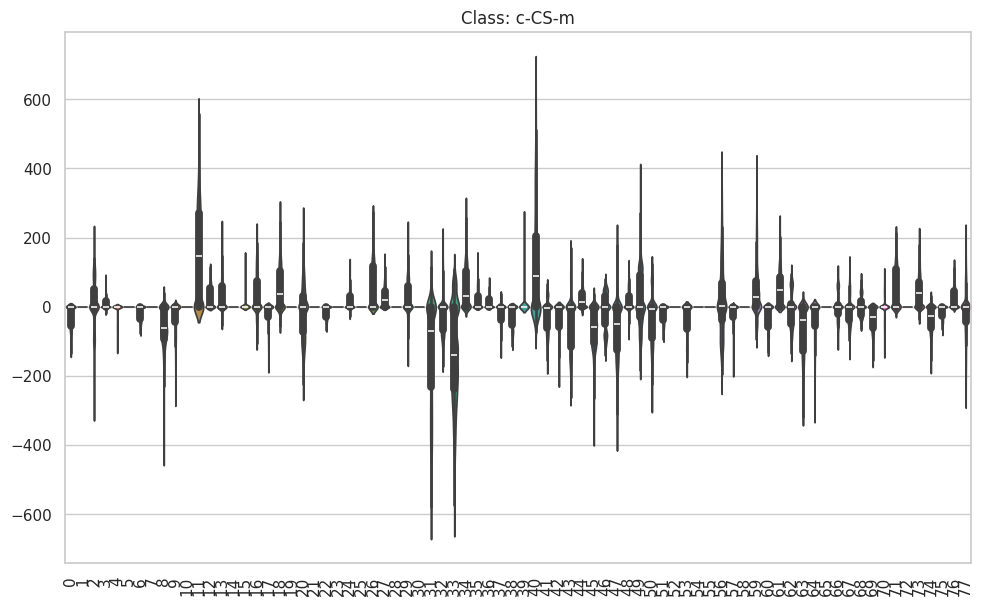

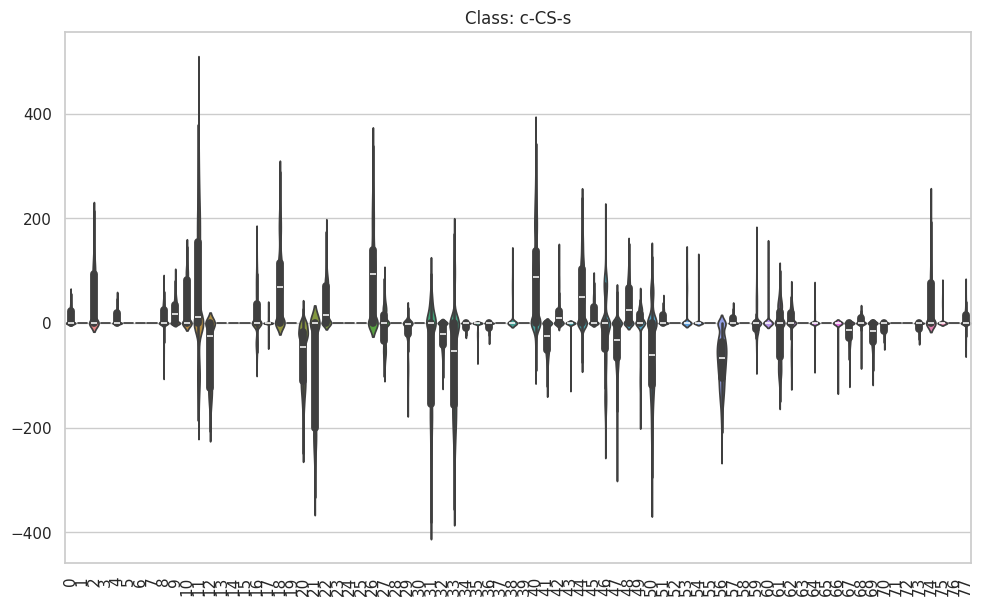

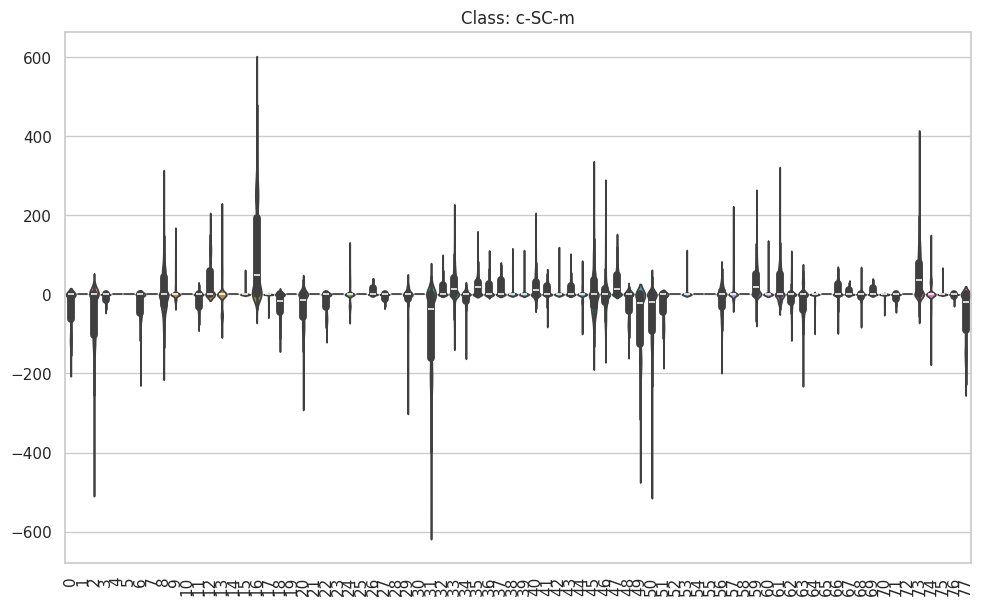

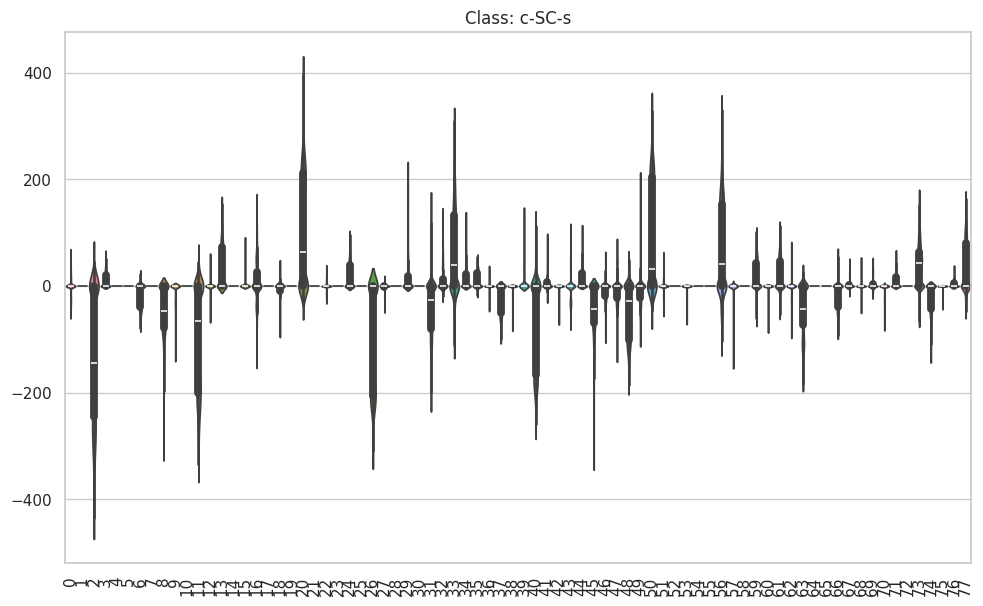

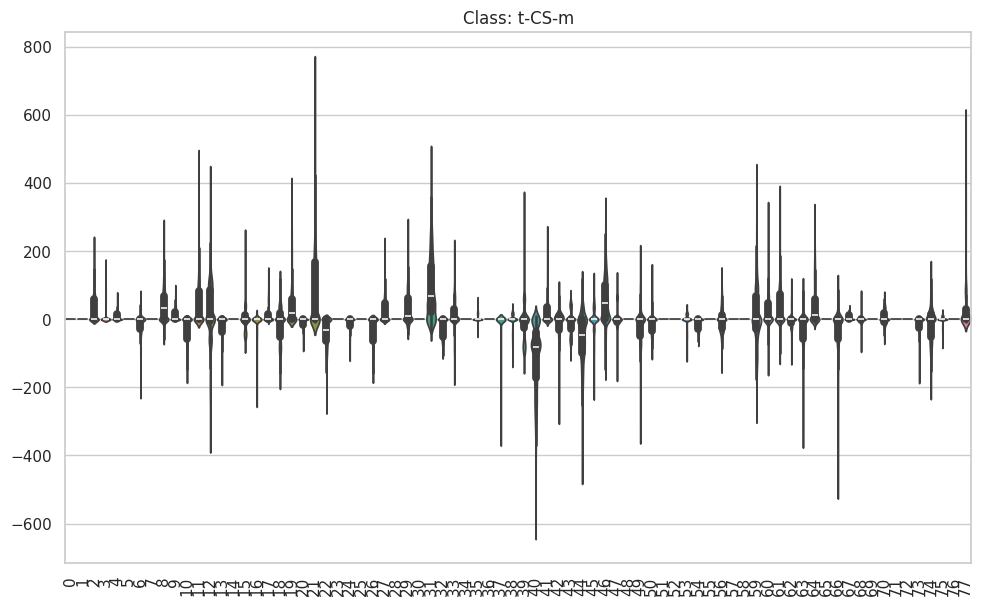

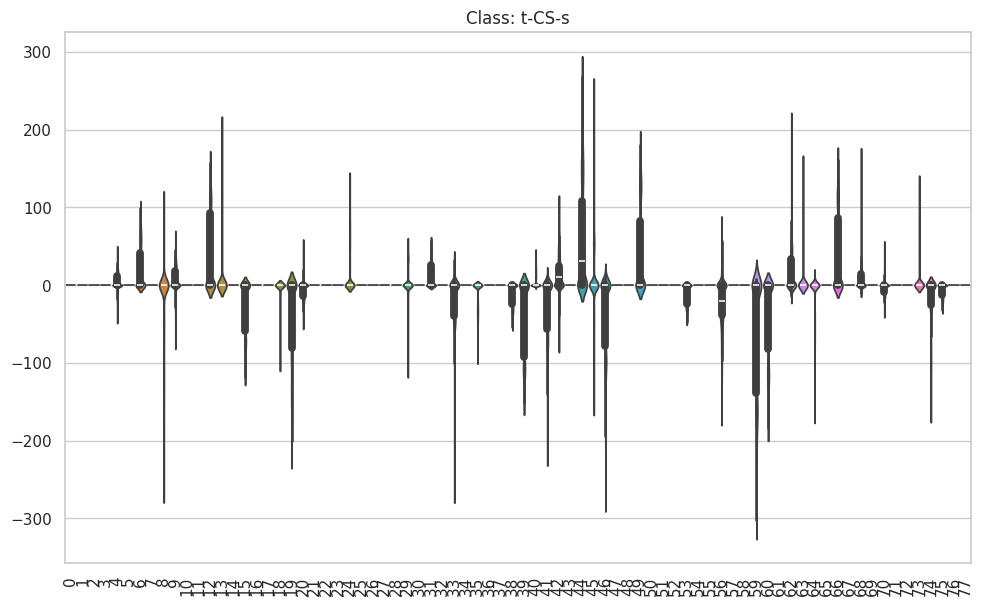

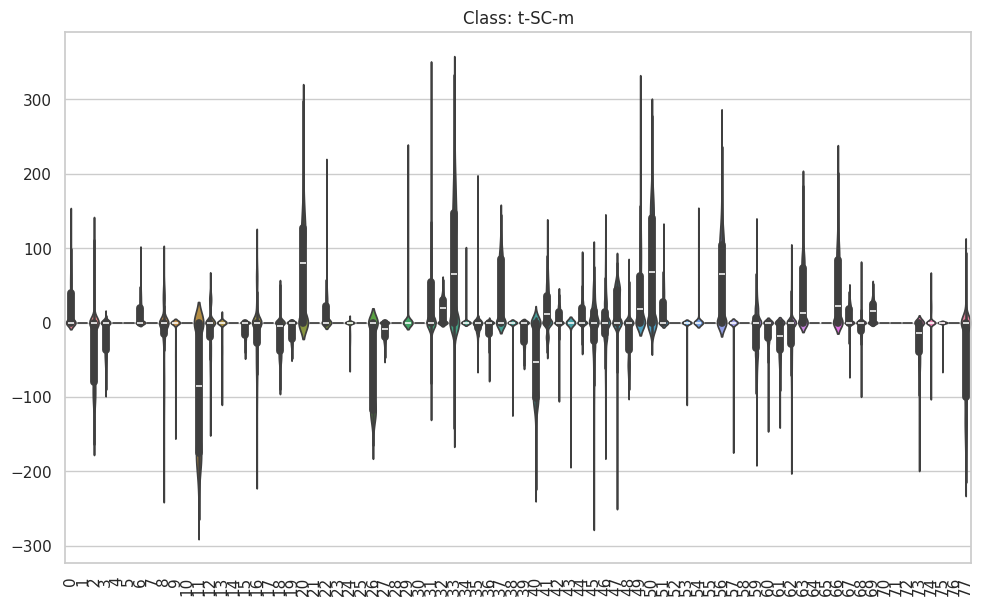

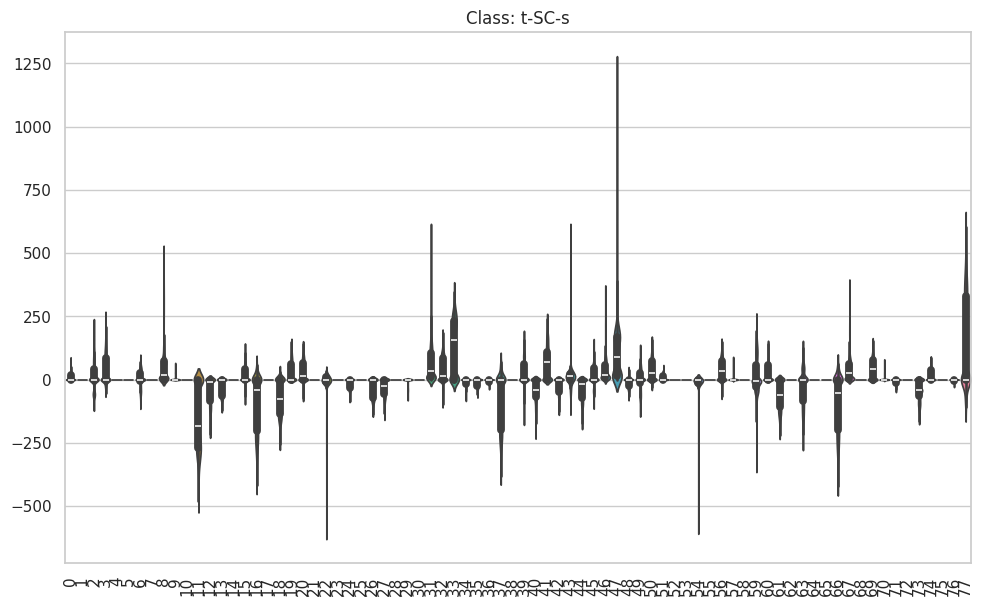

In [12]:
for c in range(n_classes):
    df = pd.DataFrame(contributions_lin[:,:,:,c].reshape(len(X_train_original)*num_samp,-1))
    plt.figure(figsize=(10,6))
    sns.set(style="whitegrid")
    sns.violinplot(df)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title(f"Class: {class_names[c]}")
    plt.savefig(f"imgs/global_explain_mice_class_{class_names[c]}.png")
    plt.show()

In [13]:
# Reset plot settings
sns.reset_orig()
plt.clf()
plt.close()

## Local explanation

### Magnitude

True output value: 3 --> c-SC-s


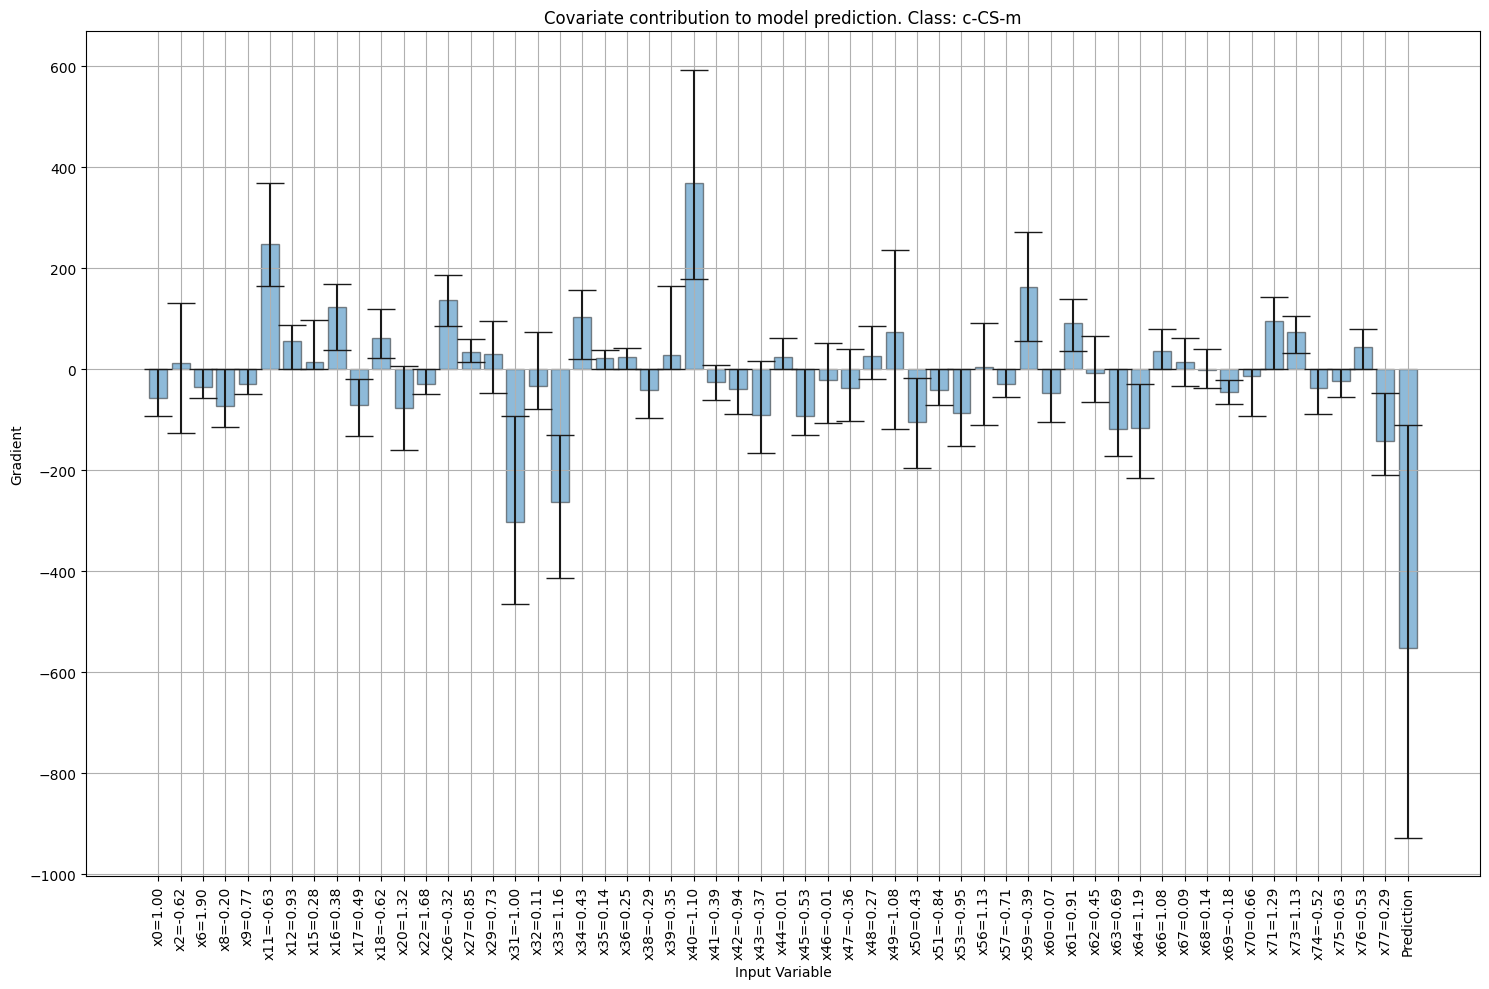

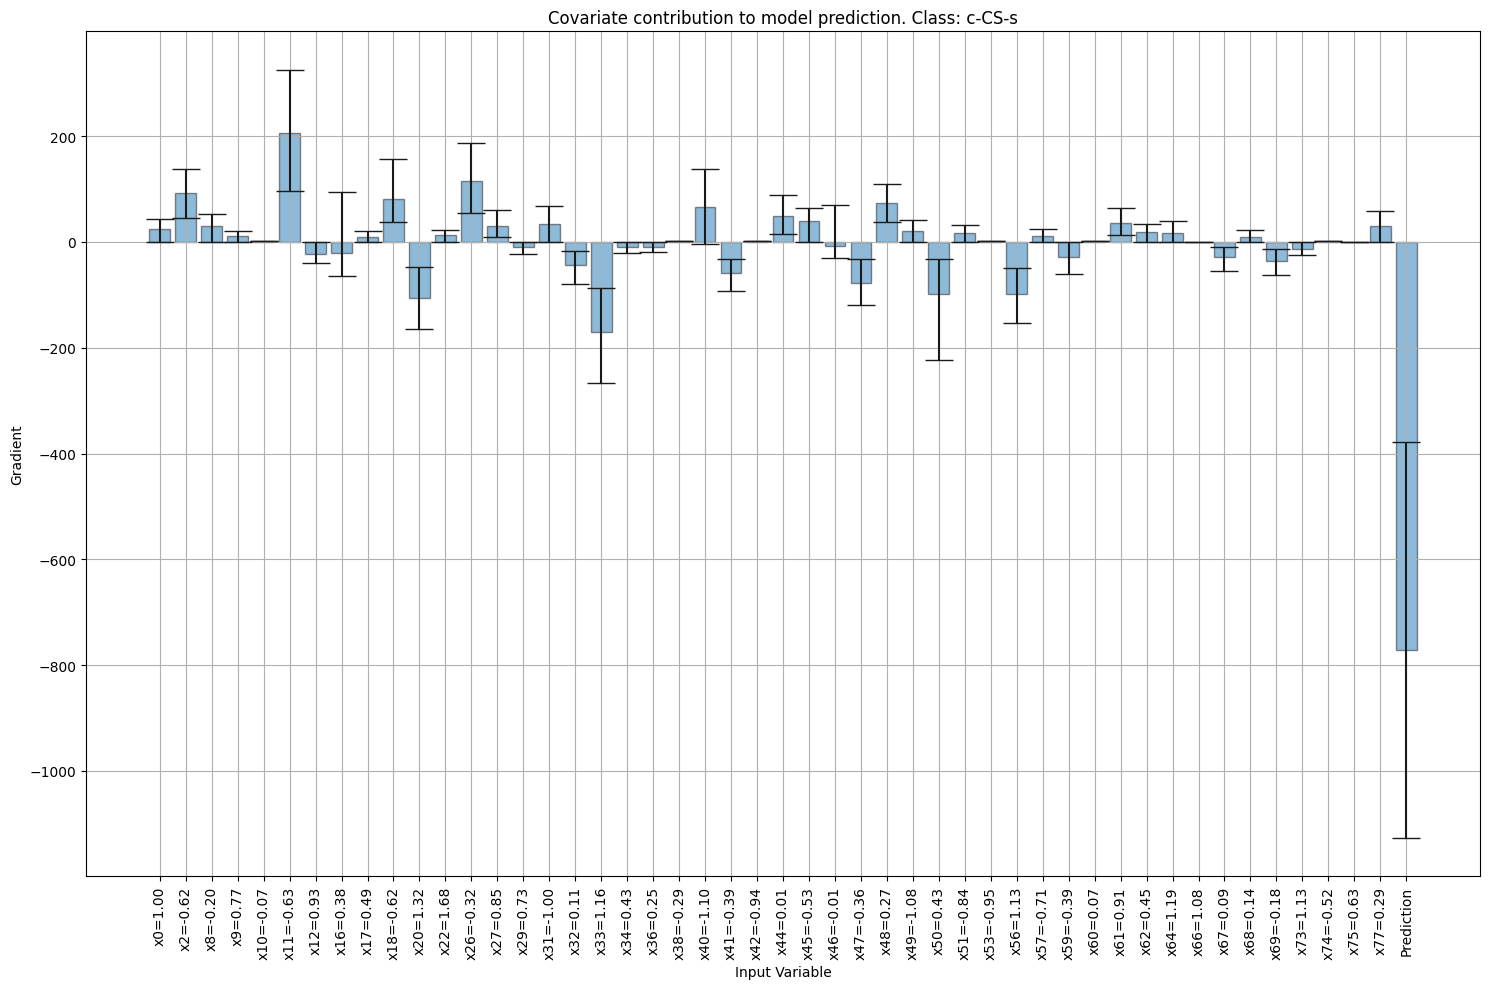

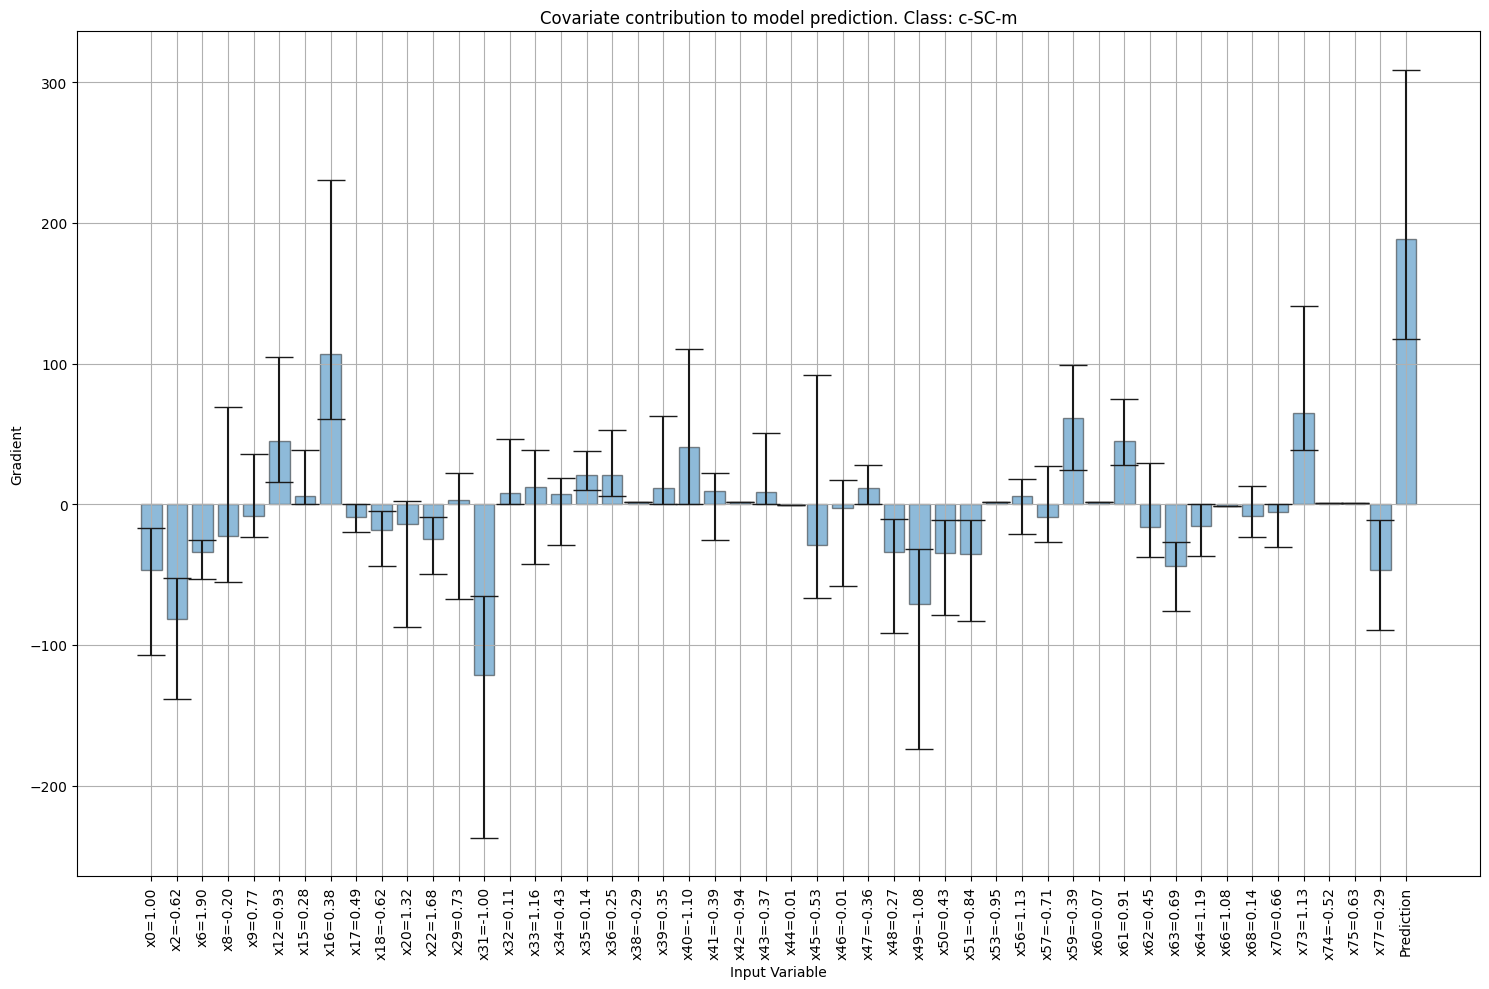

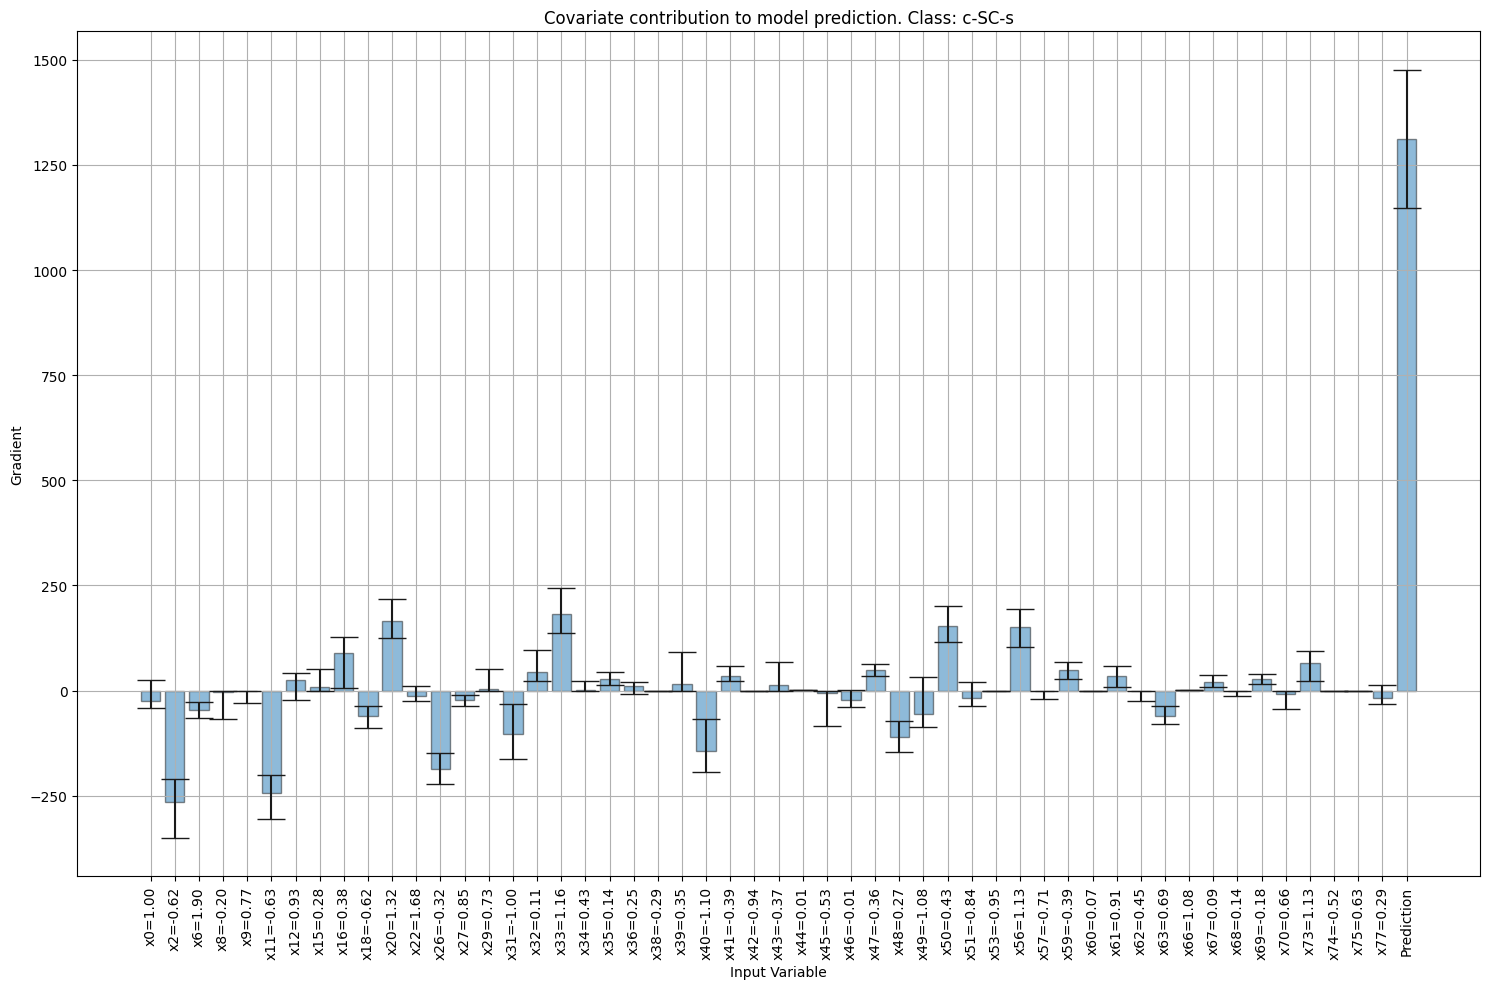

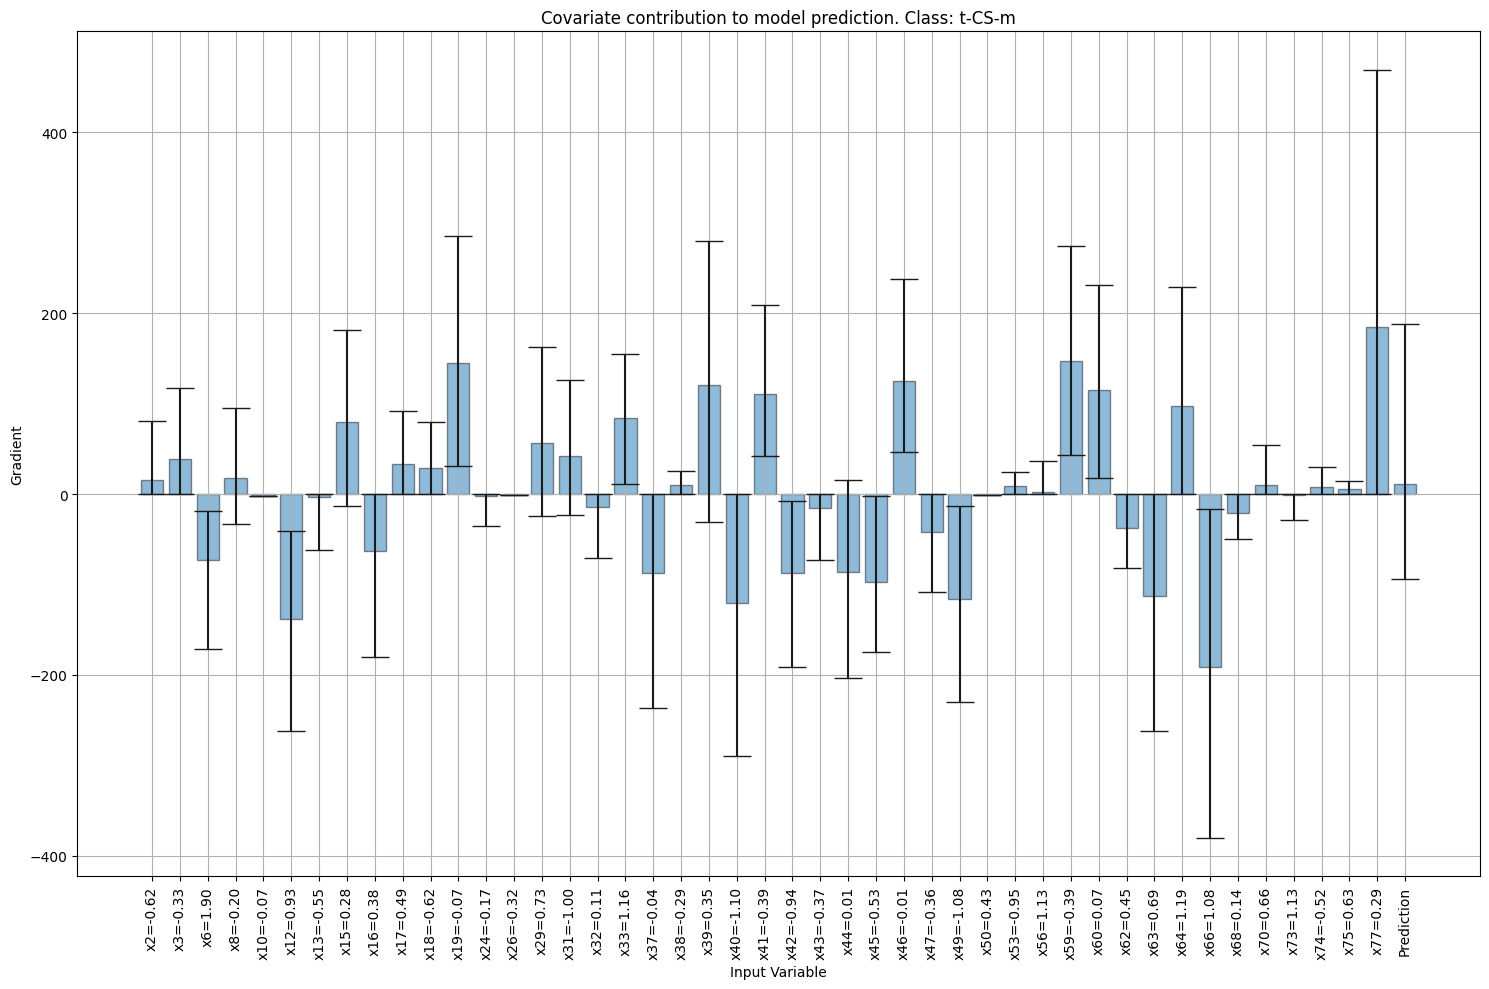

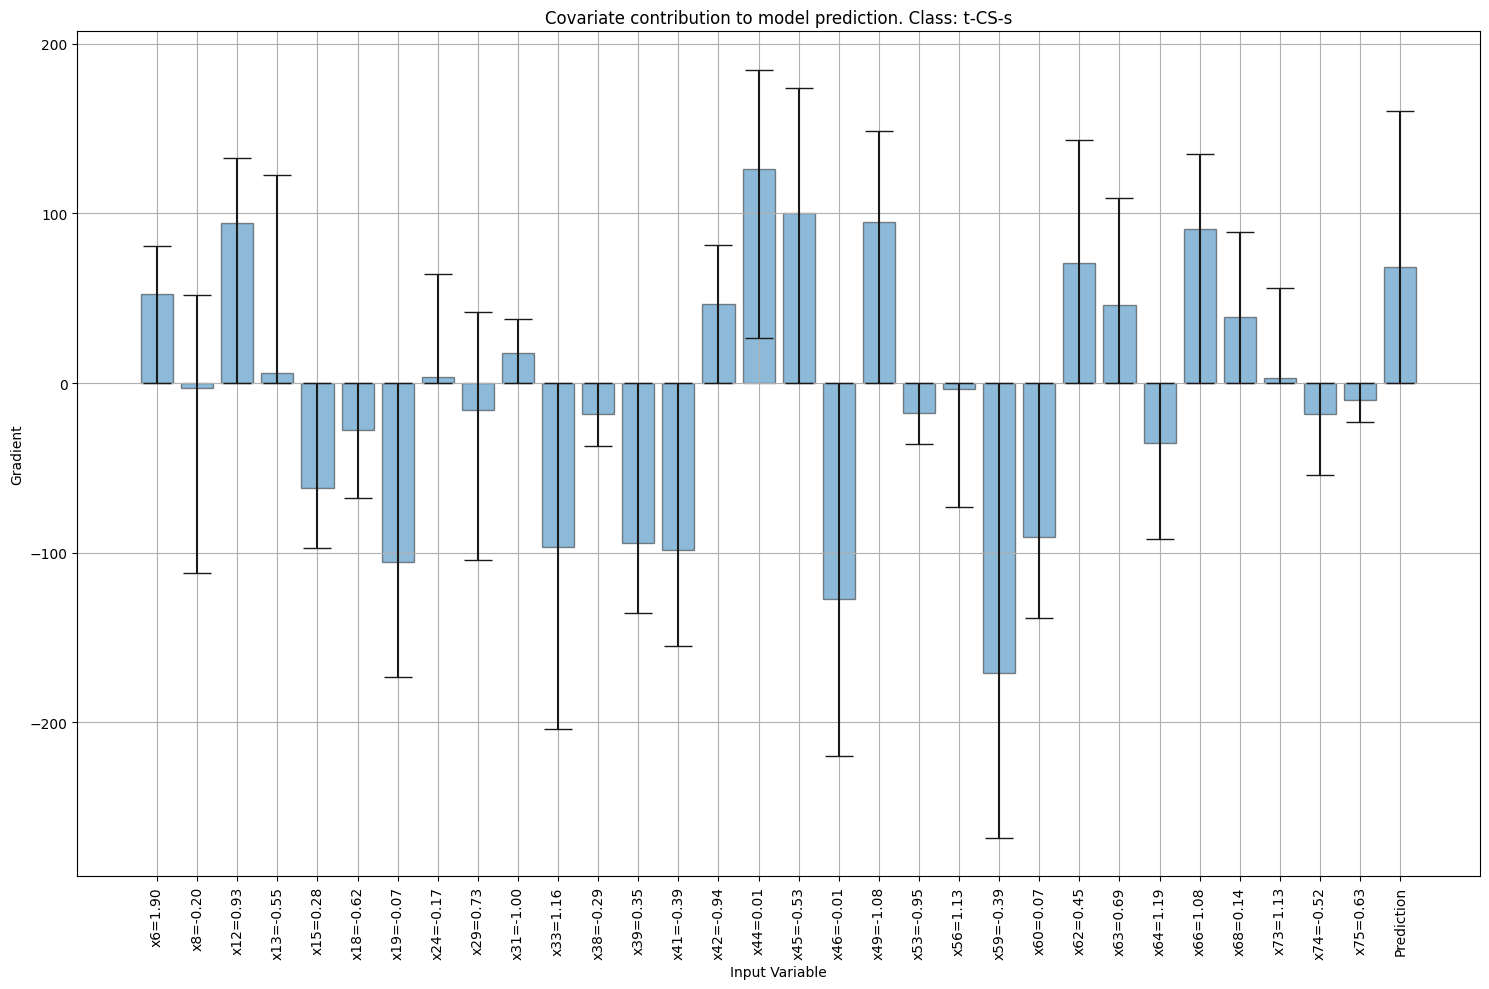

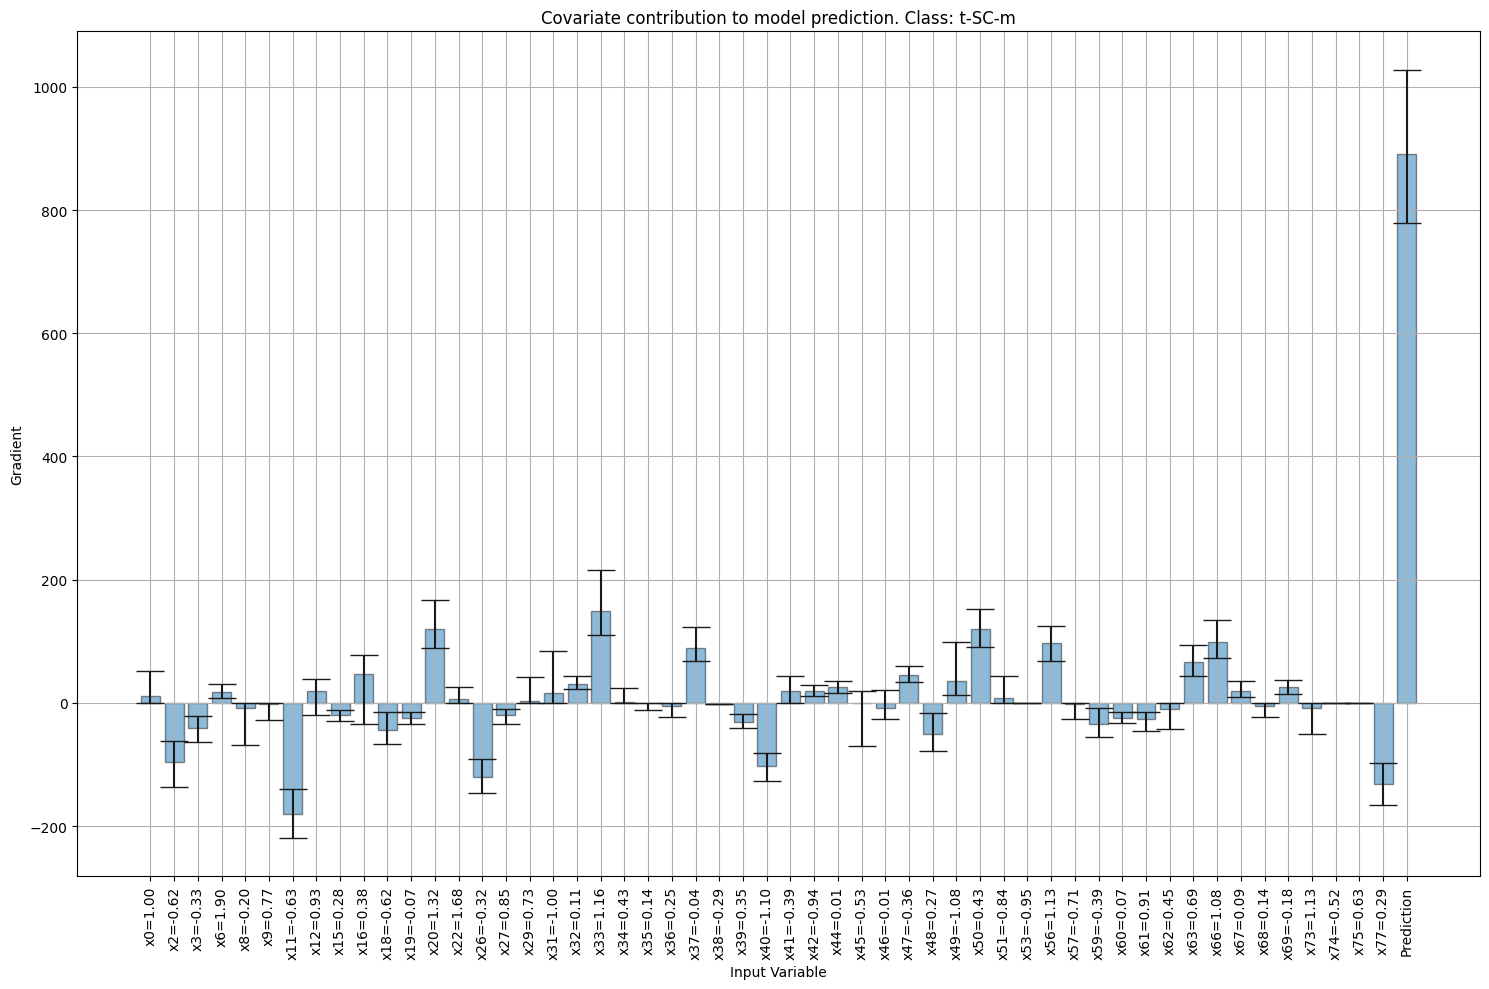

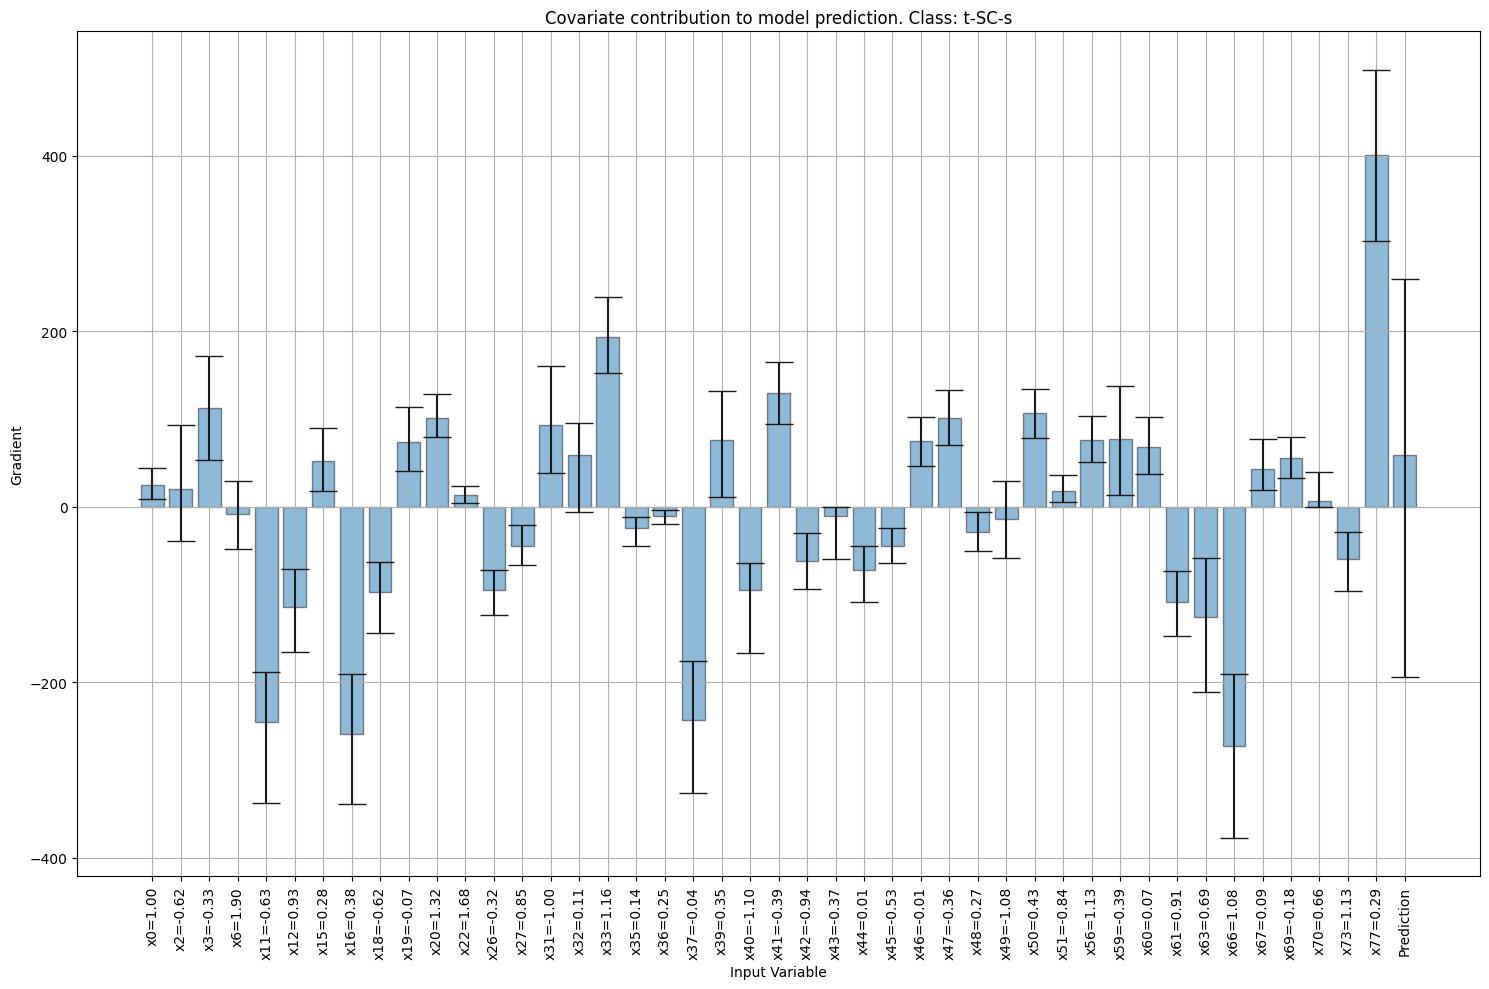

In [14]:
i = 15
explain_this = test_dat[i,:-1].reshape(-1, p)[0]
output_val = test_dat[i,-1]
print(f"True output value: {int(output_val)} --> {class_names[int(output_val)]}")
pf.plot_local_explain_piecewise_linear_act(
    net, 
    explain_this, 
    n_samples=100, 
    n_classes=n_classes,
    class_names=copy.deepcopy(class_names),
    magnitude=True, 
    include_prediction=True, 
    include_bias=True, 
    fig_size=(15,10), 
    no_zero_contributions=True, 
    include_potential_contribution=False,
    save_path=f"imgs/local_contribution_output_{output_val}_class_")

True output value: 1 --> c-CS-s


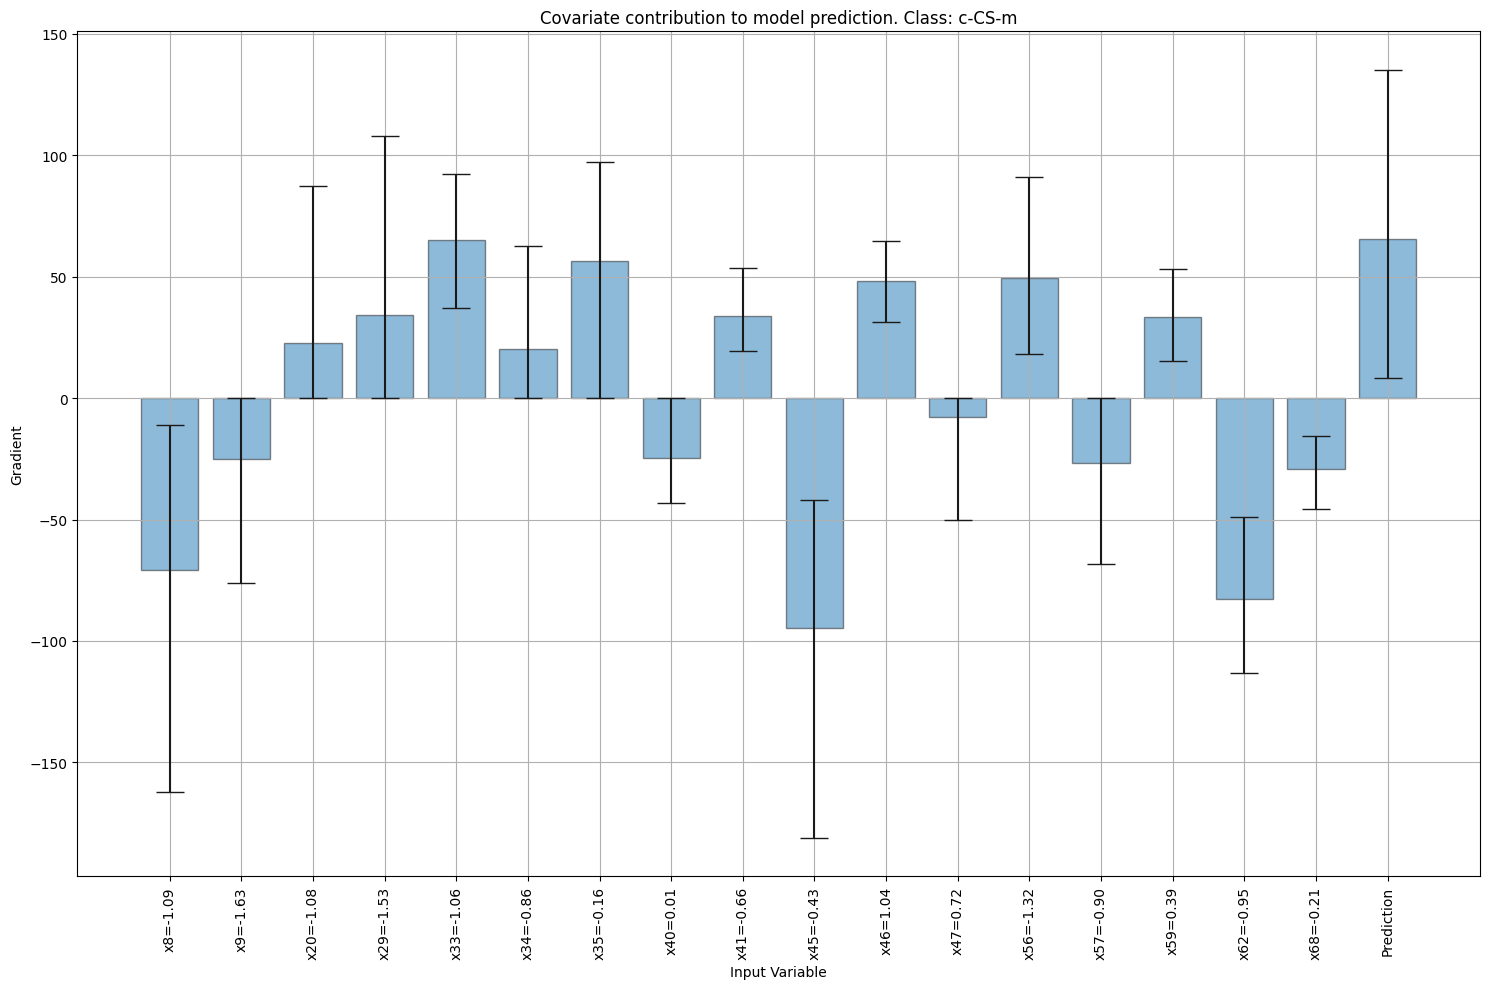

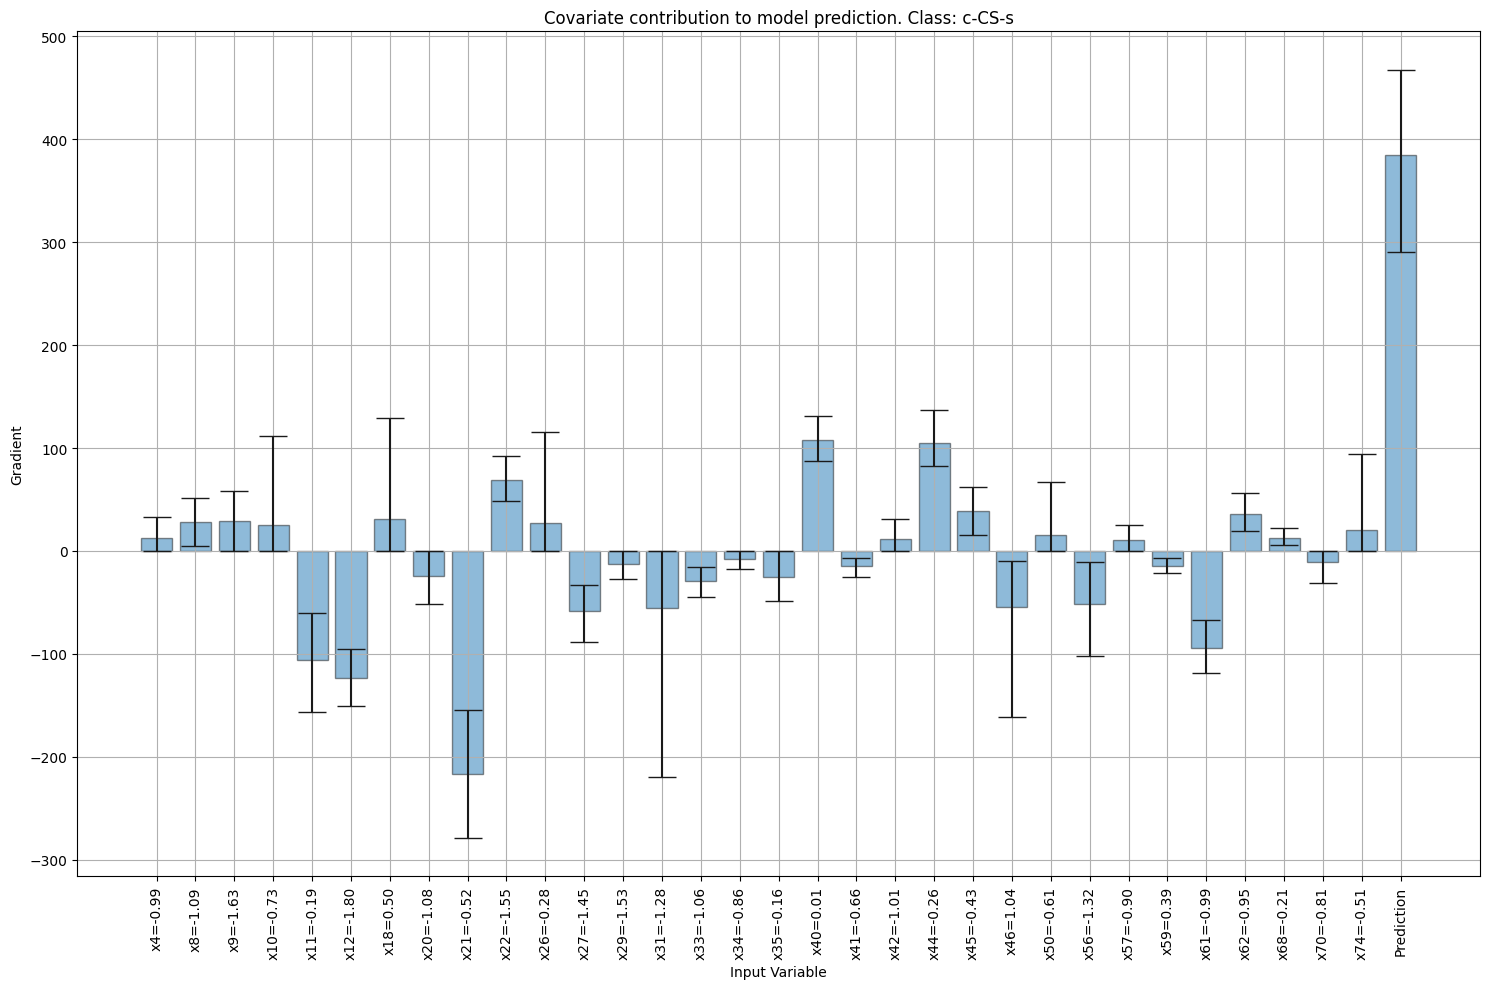

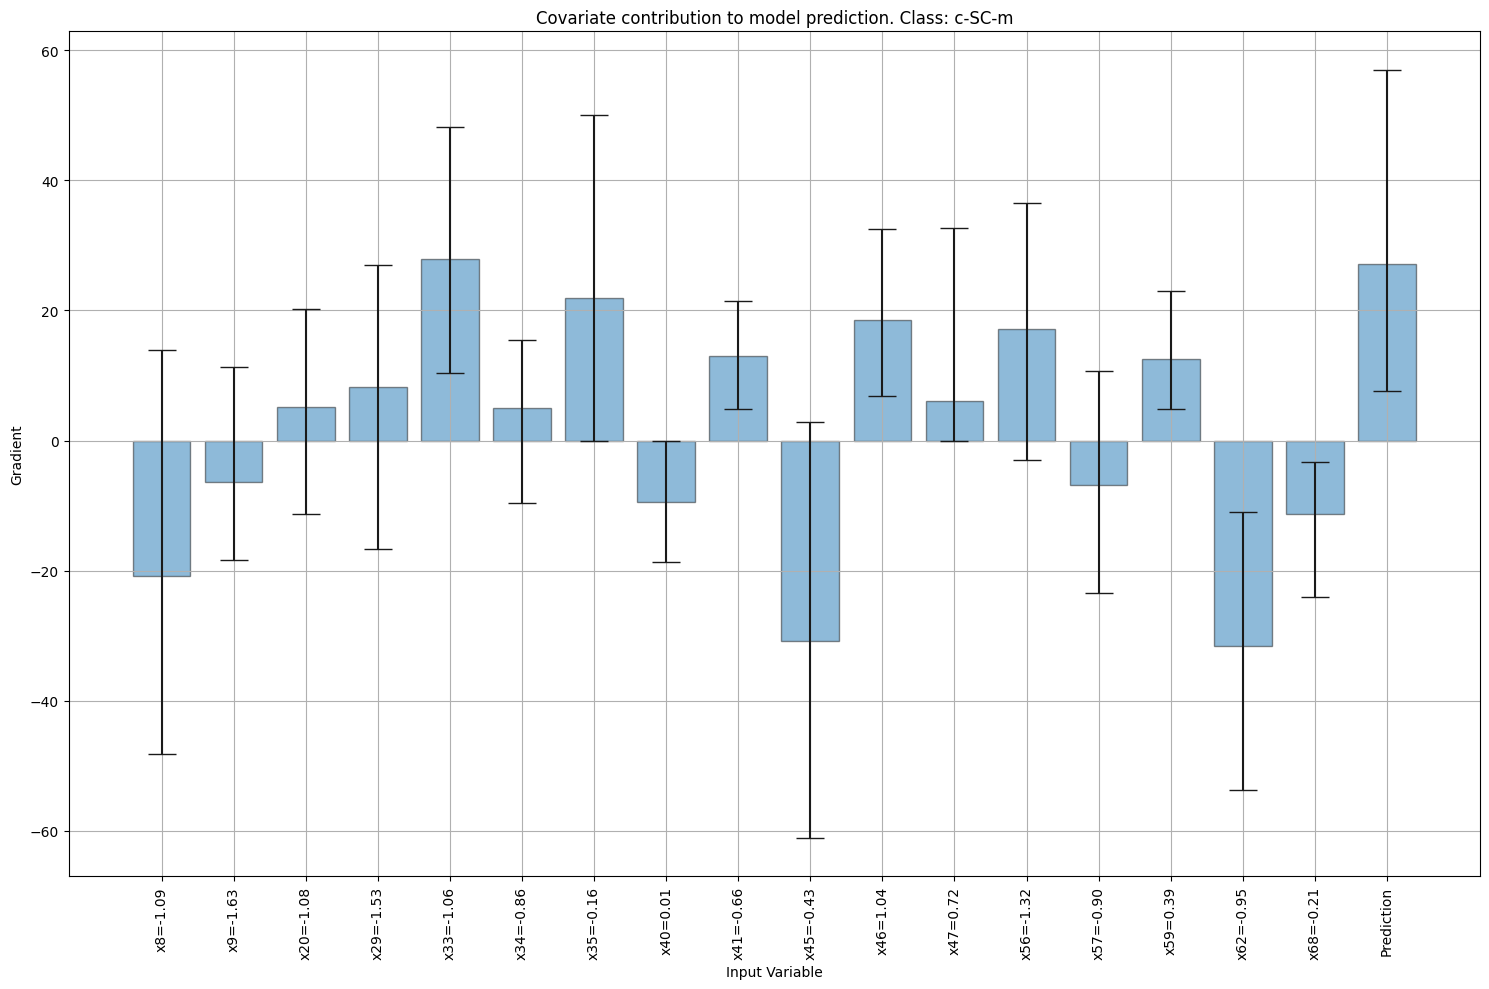

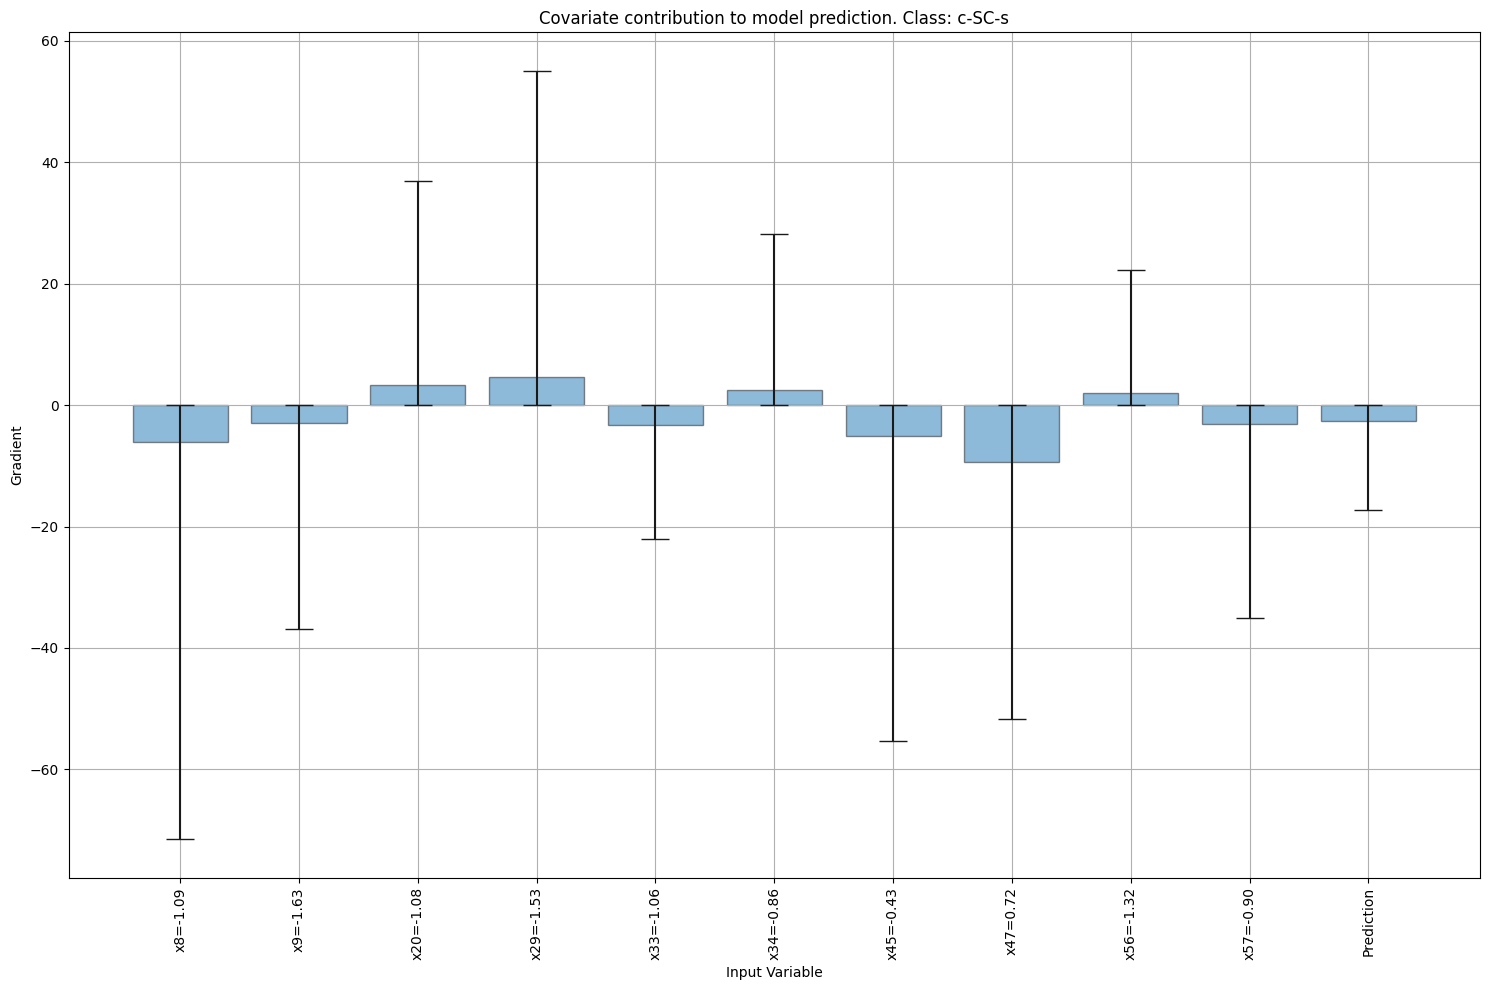

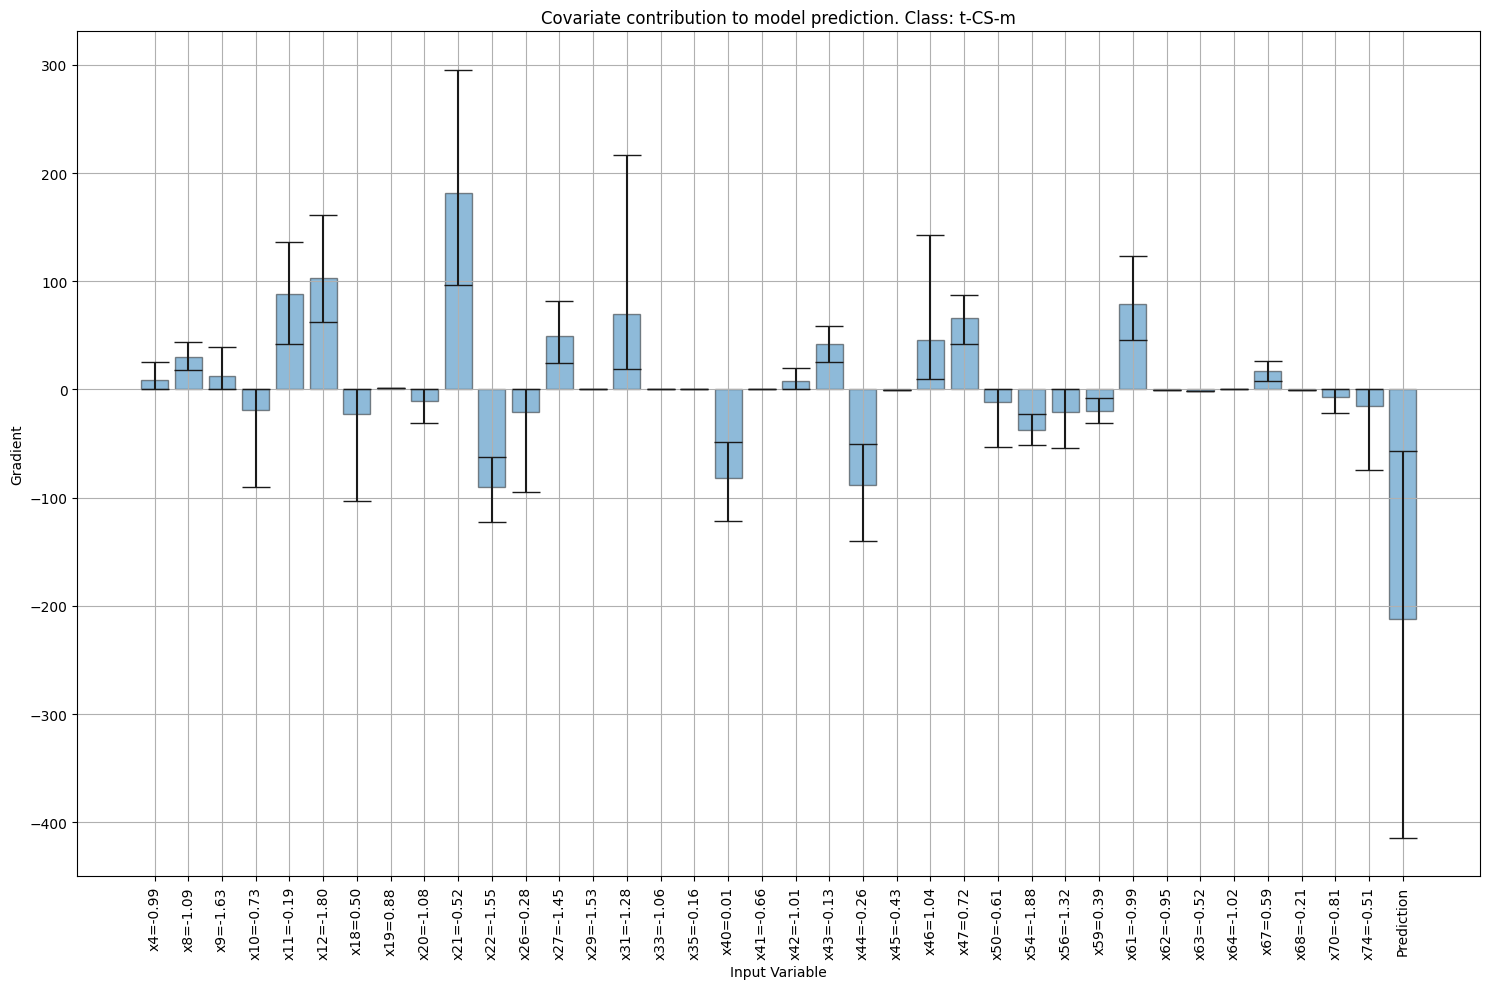

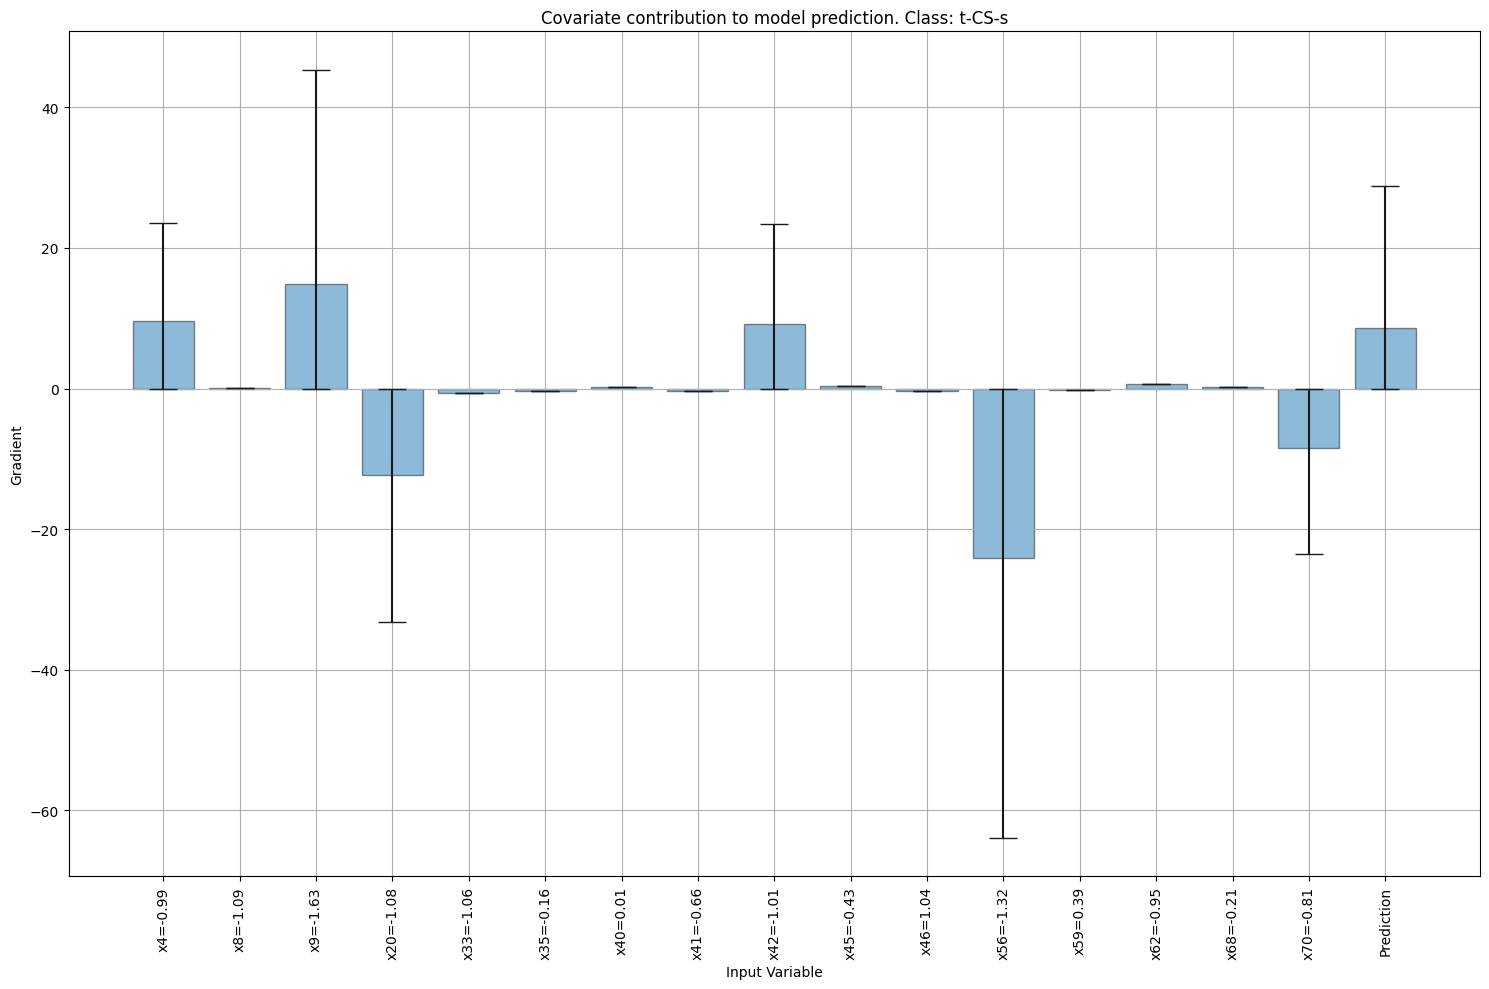

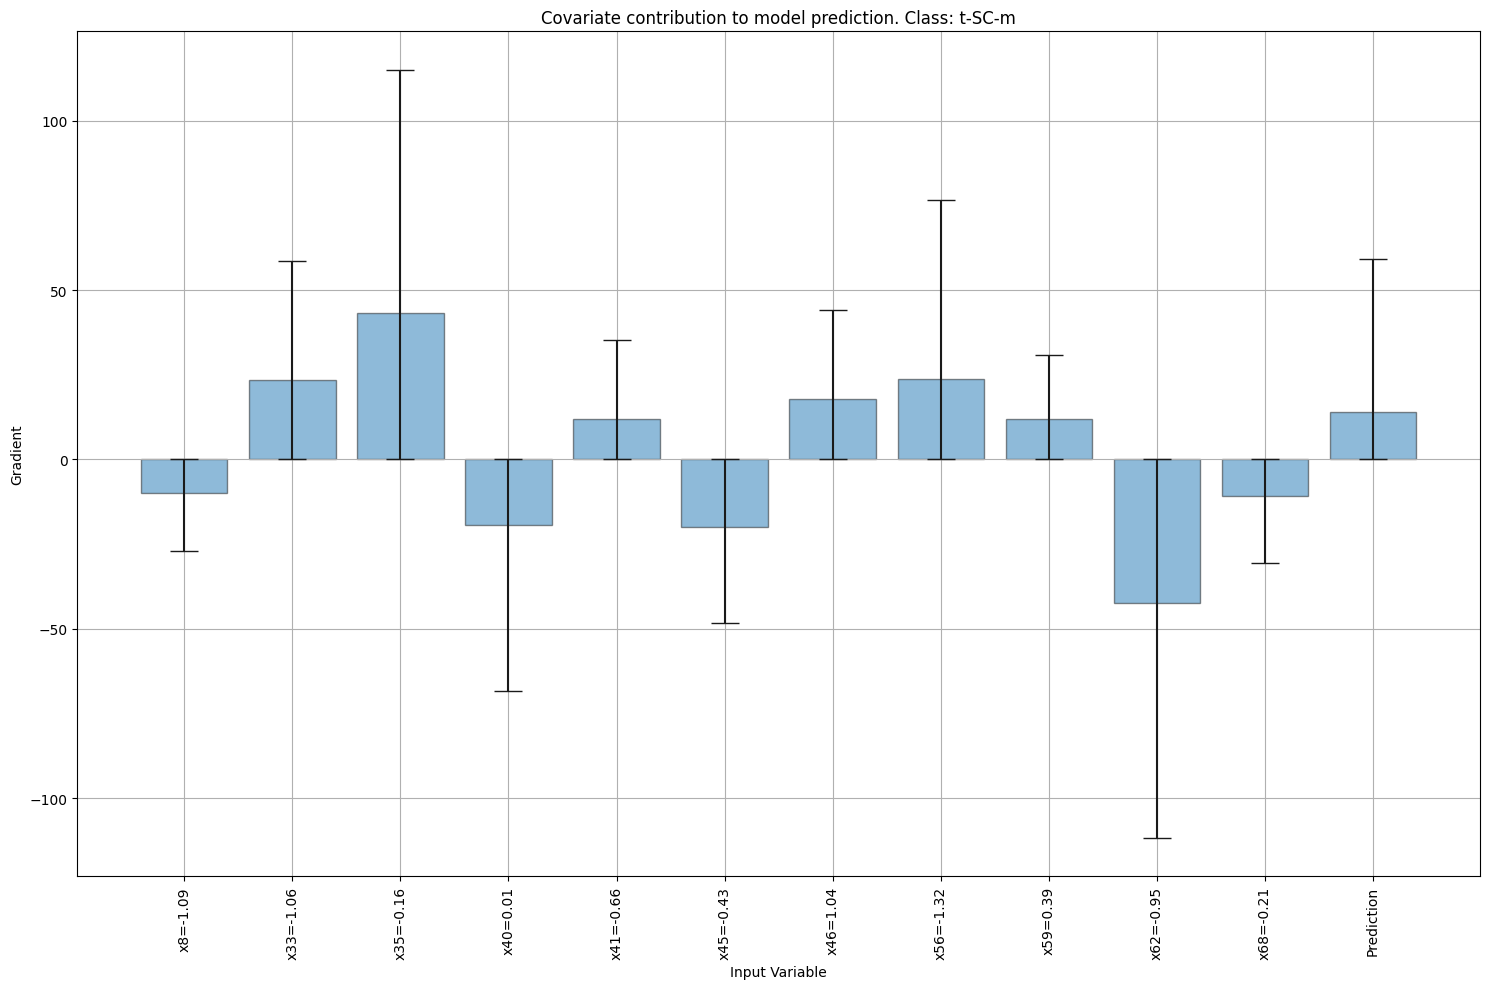

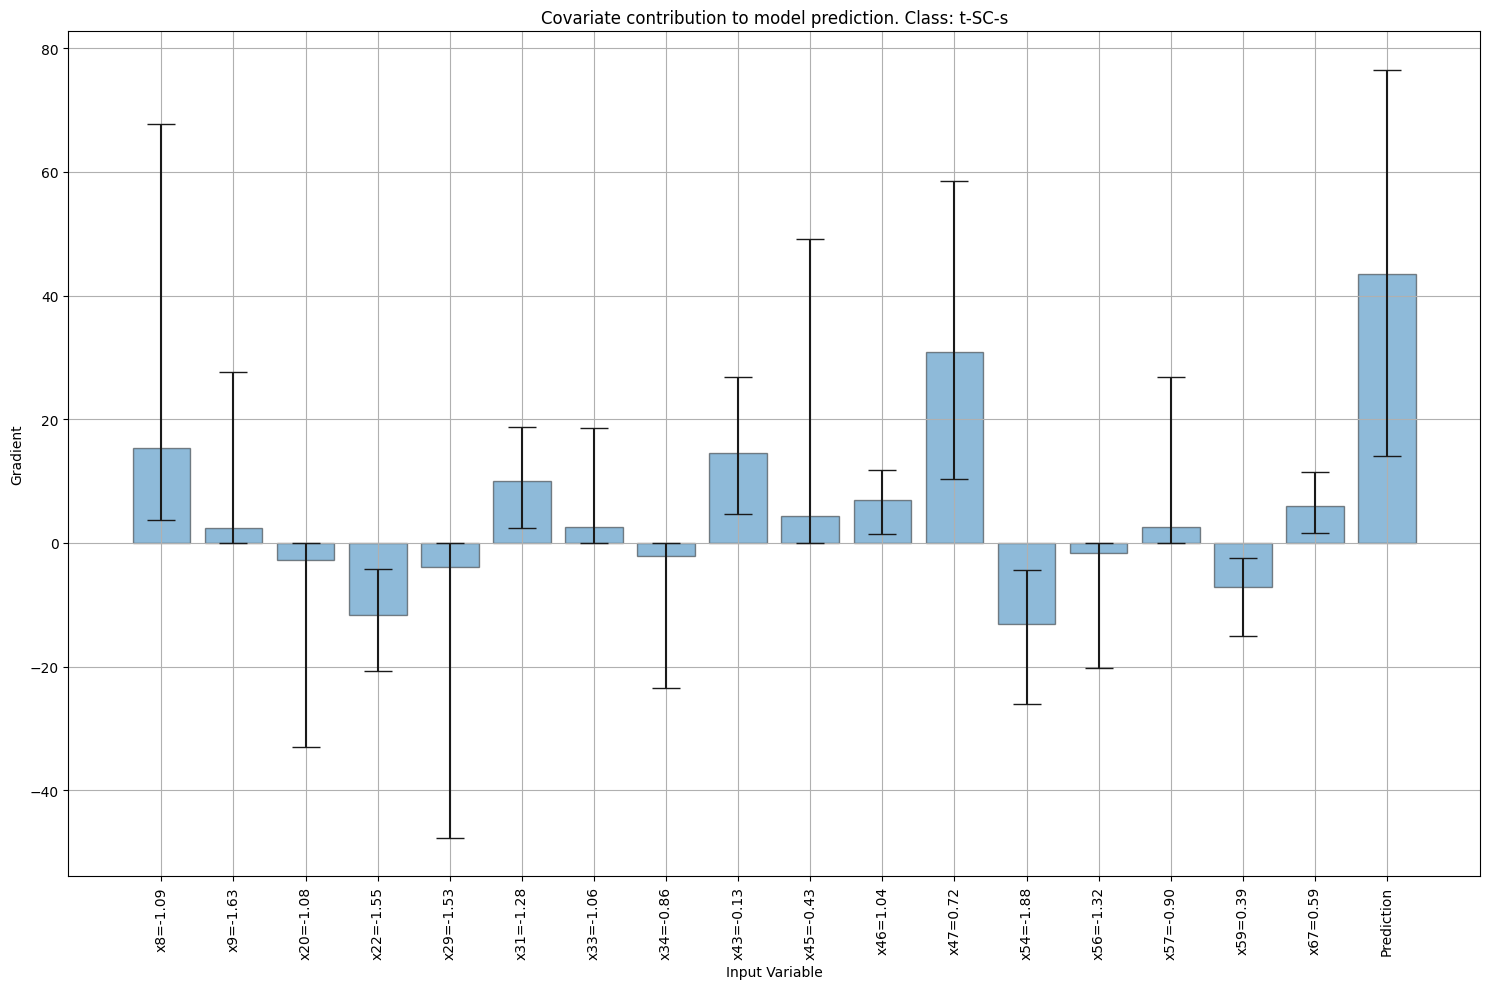

In [15]:
i = 10
explain_this = test_dat[i,:-1].reshape(-1, p)[0]
output_val = test_dat[i,-1]
print(f"True output value: {int(output_val)} --> {class_names[int(output_val)]}")
pf.plot_local_explain_piecewise_linear_act(
    net, 
    explain_this, 
    n_samples=100, 
    n_classes=n_classes,
    class_names=copy.deepcopy(class_names),
    magnitude=True, 
    include_prediction=True, 
    include_bias=True, 
    fig_size=(15,10), 
    no_zero_contributions=True, 
    include_potential_contribution=False,
    save_path=f"imgs/local_contribution_output_{output_val}_class_")

### Actual contribution

True output value: 3 --> c-SC-s


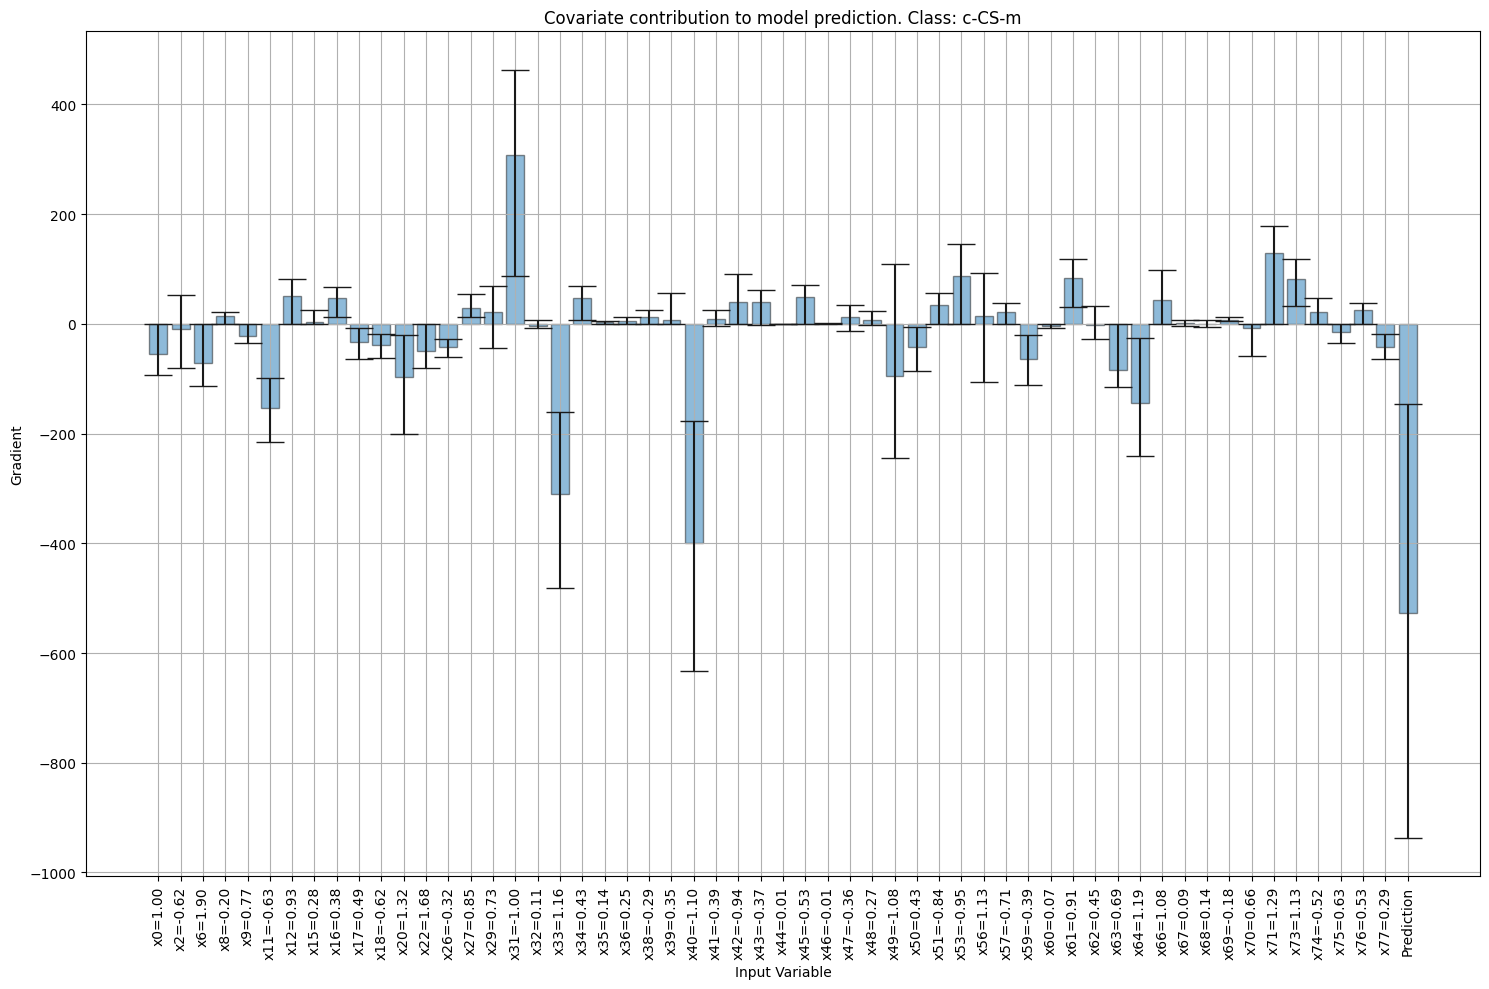

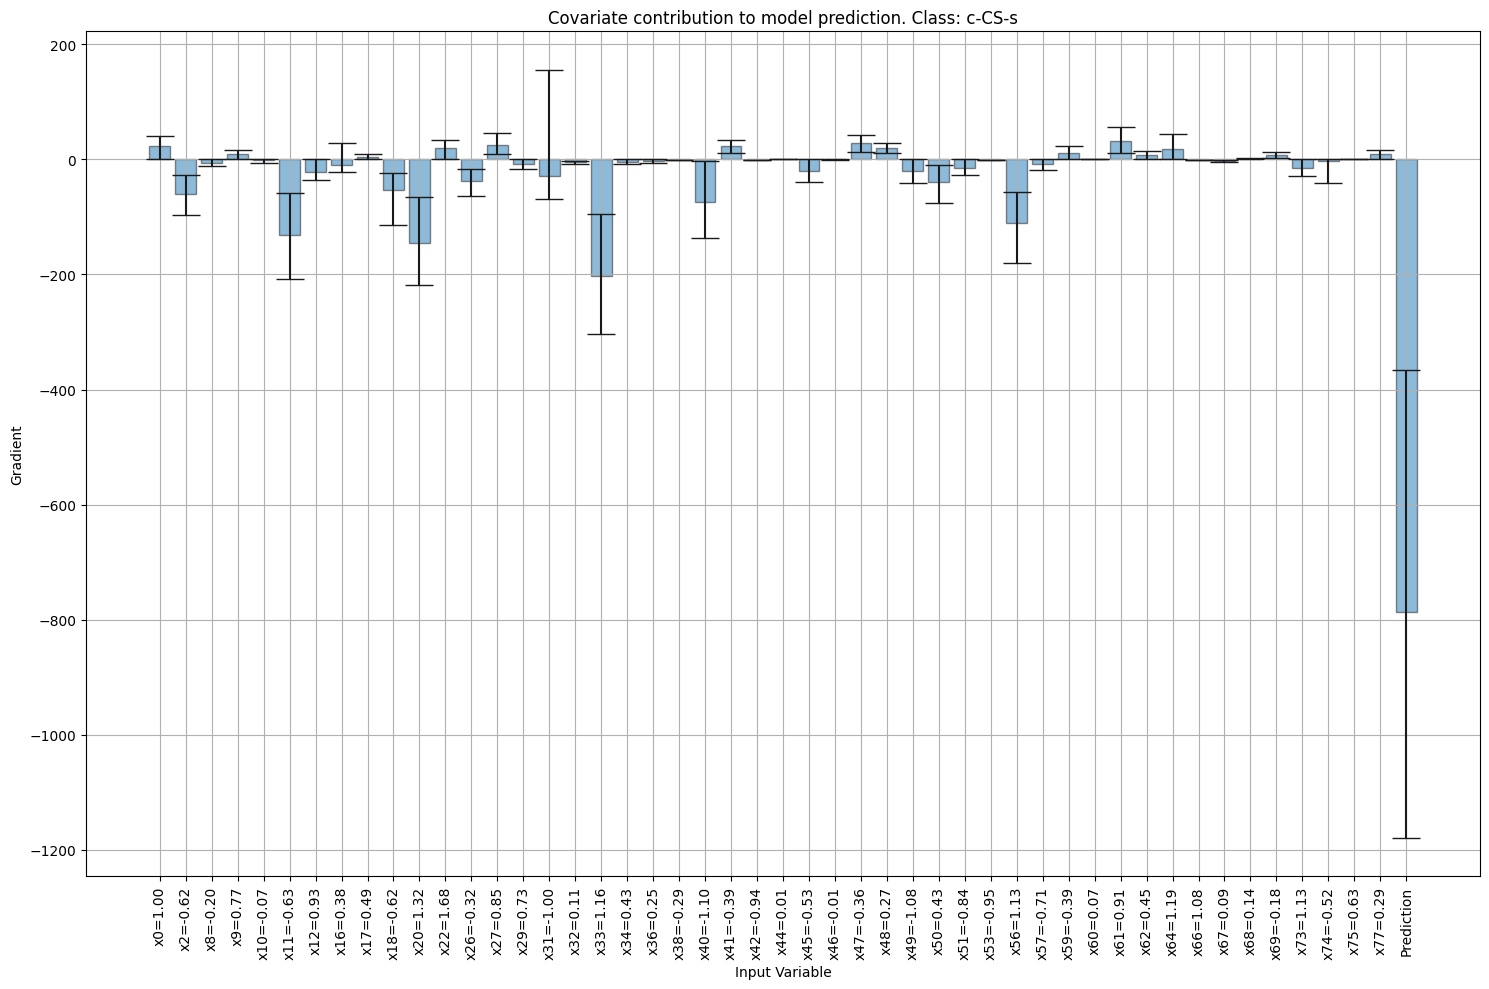

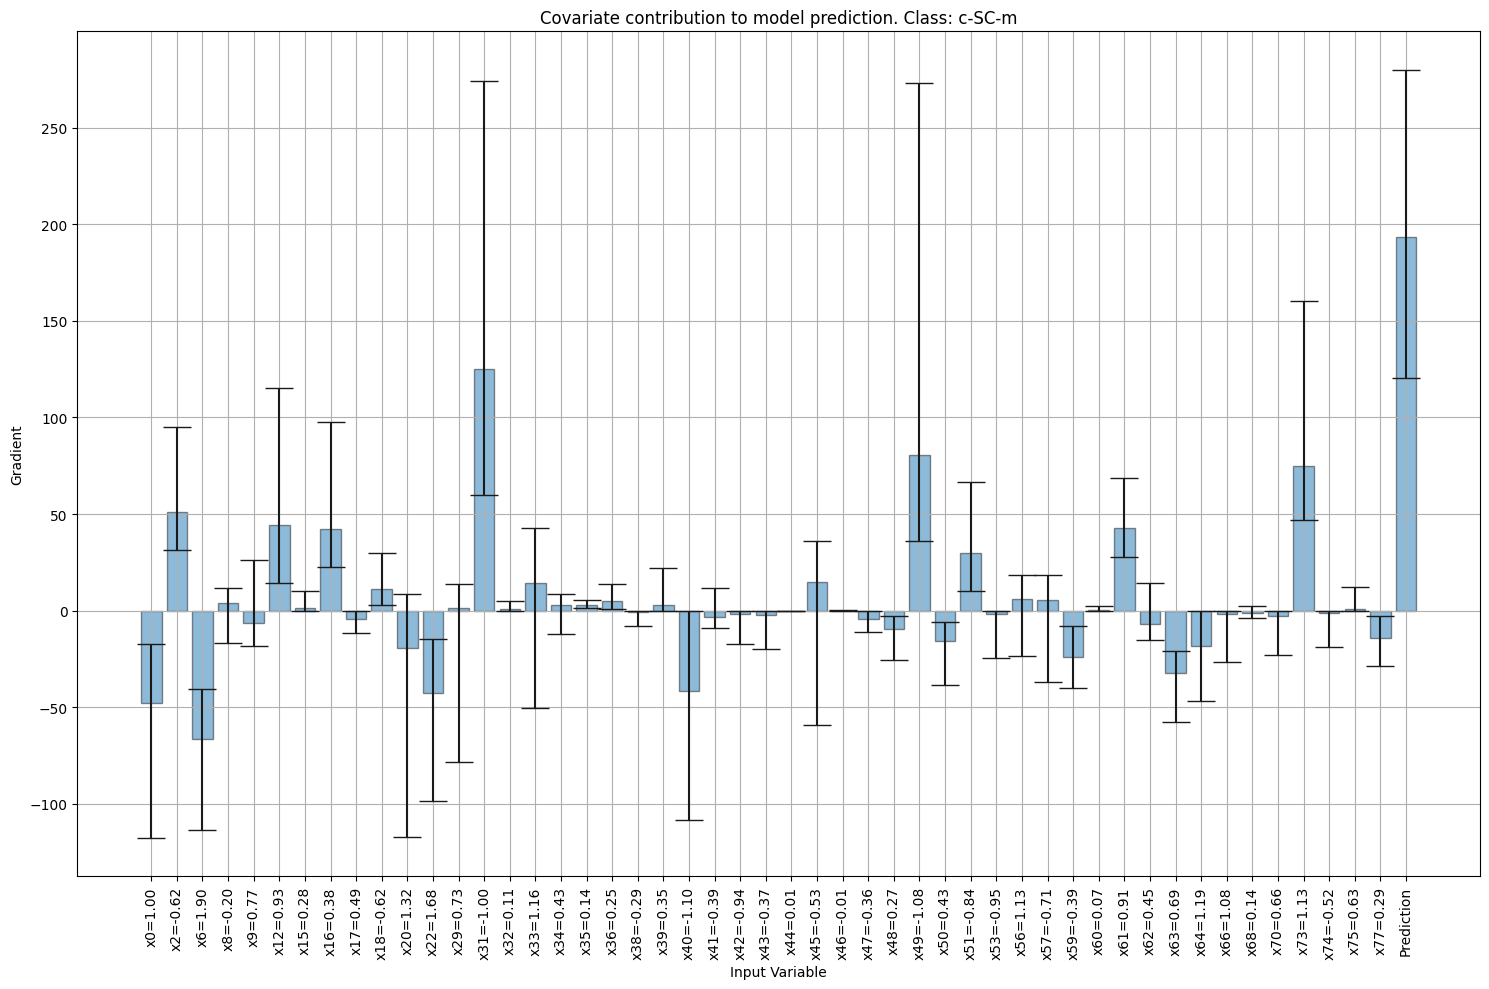

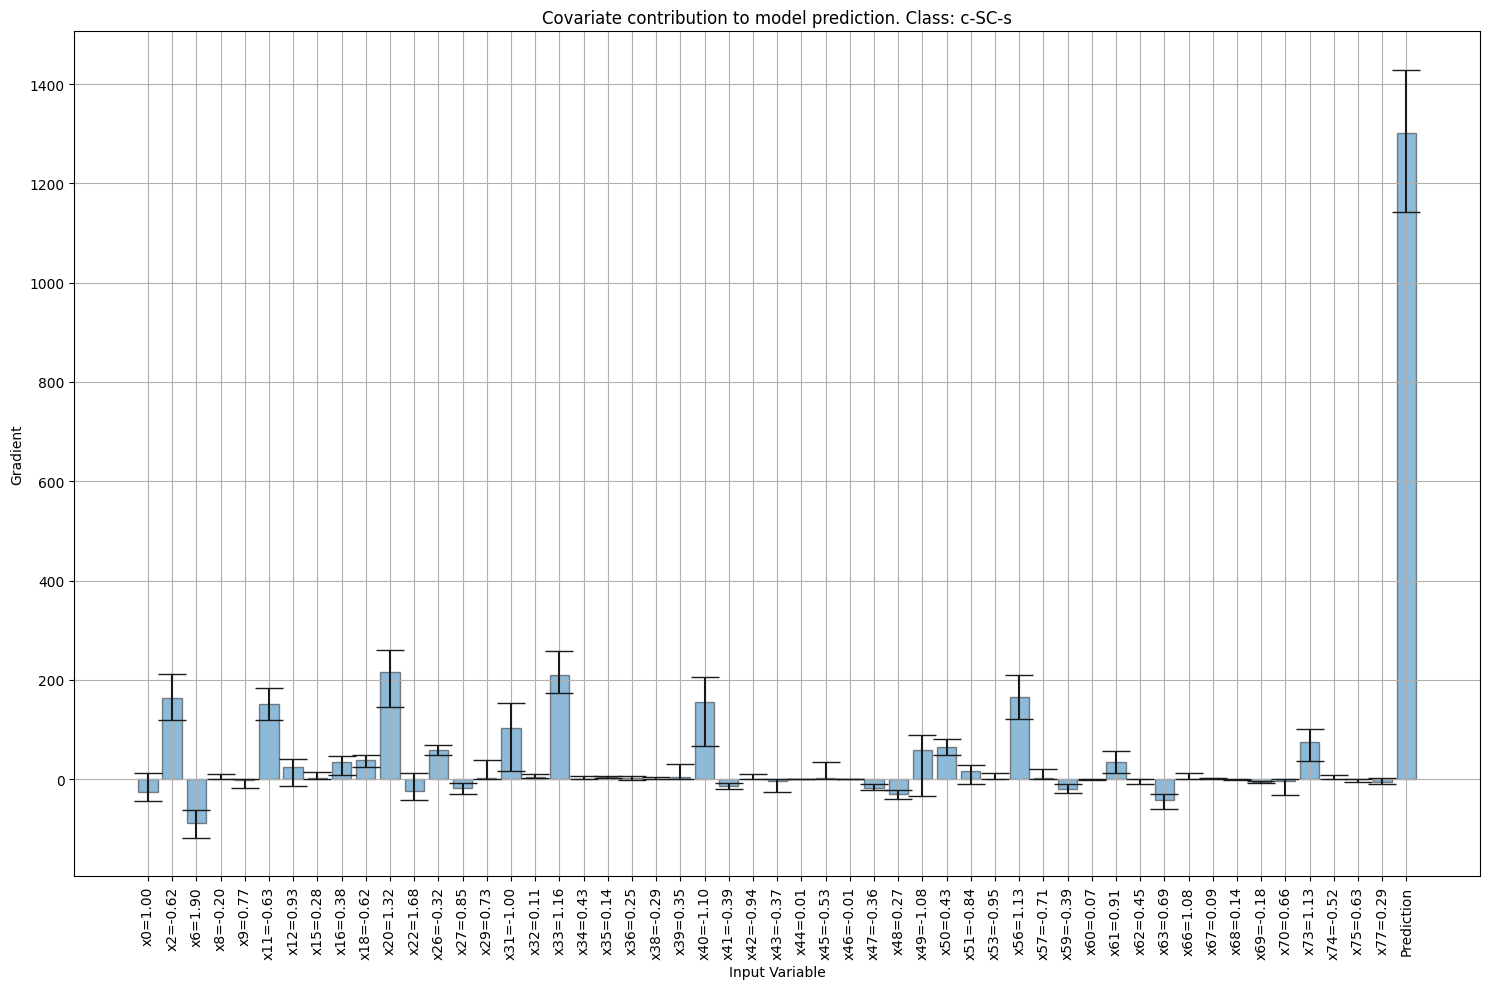

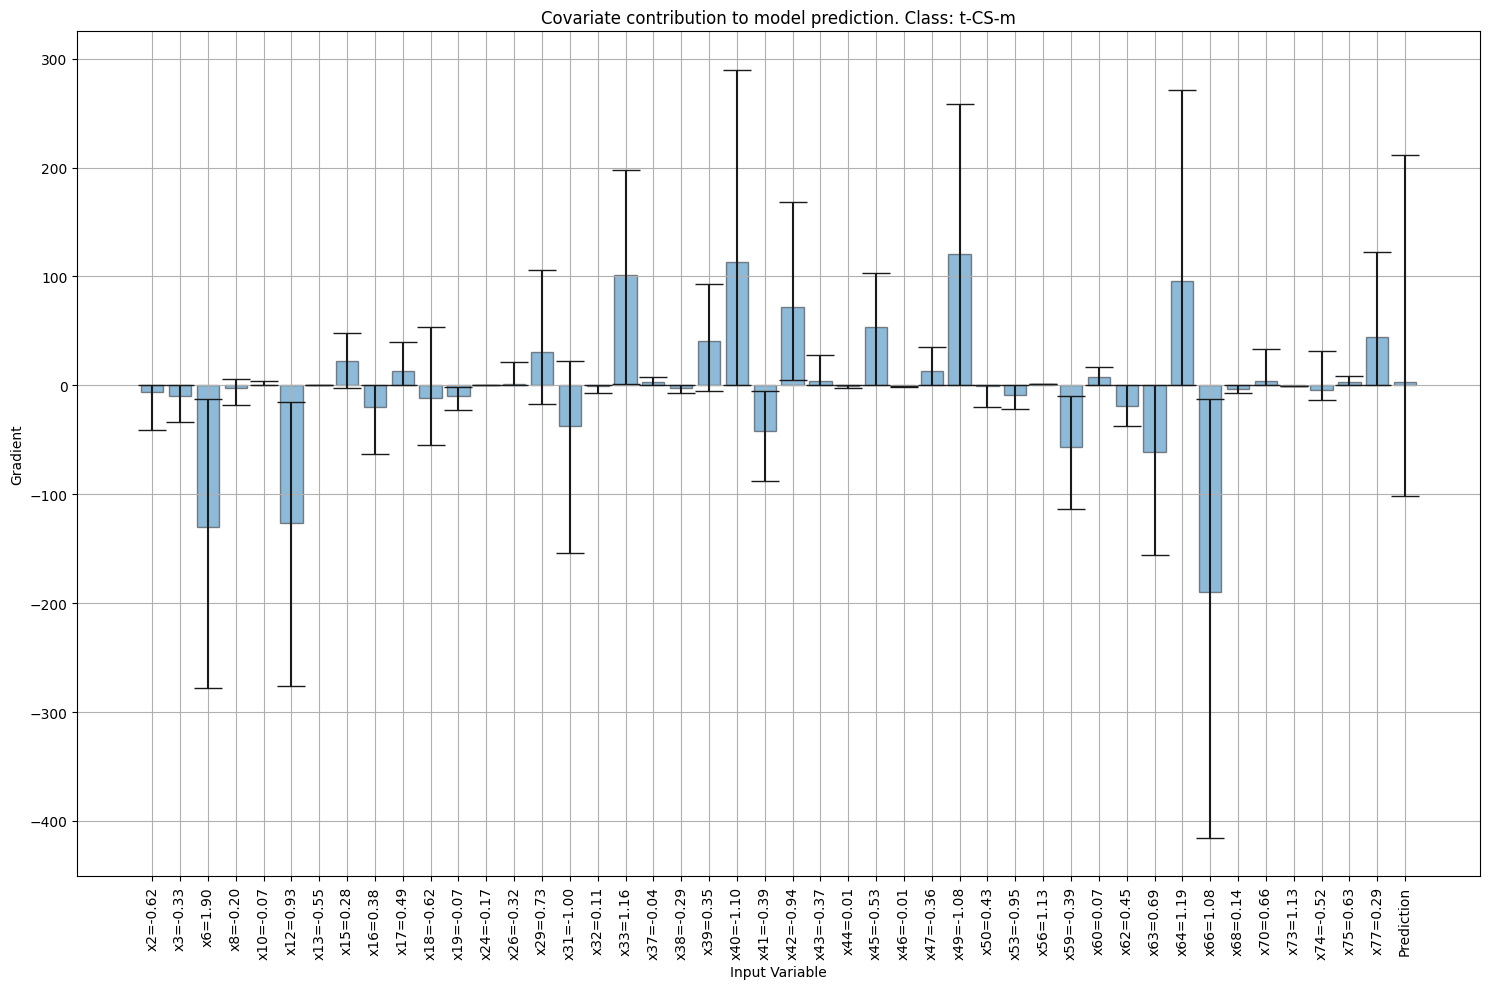

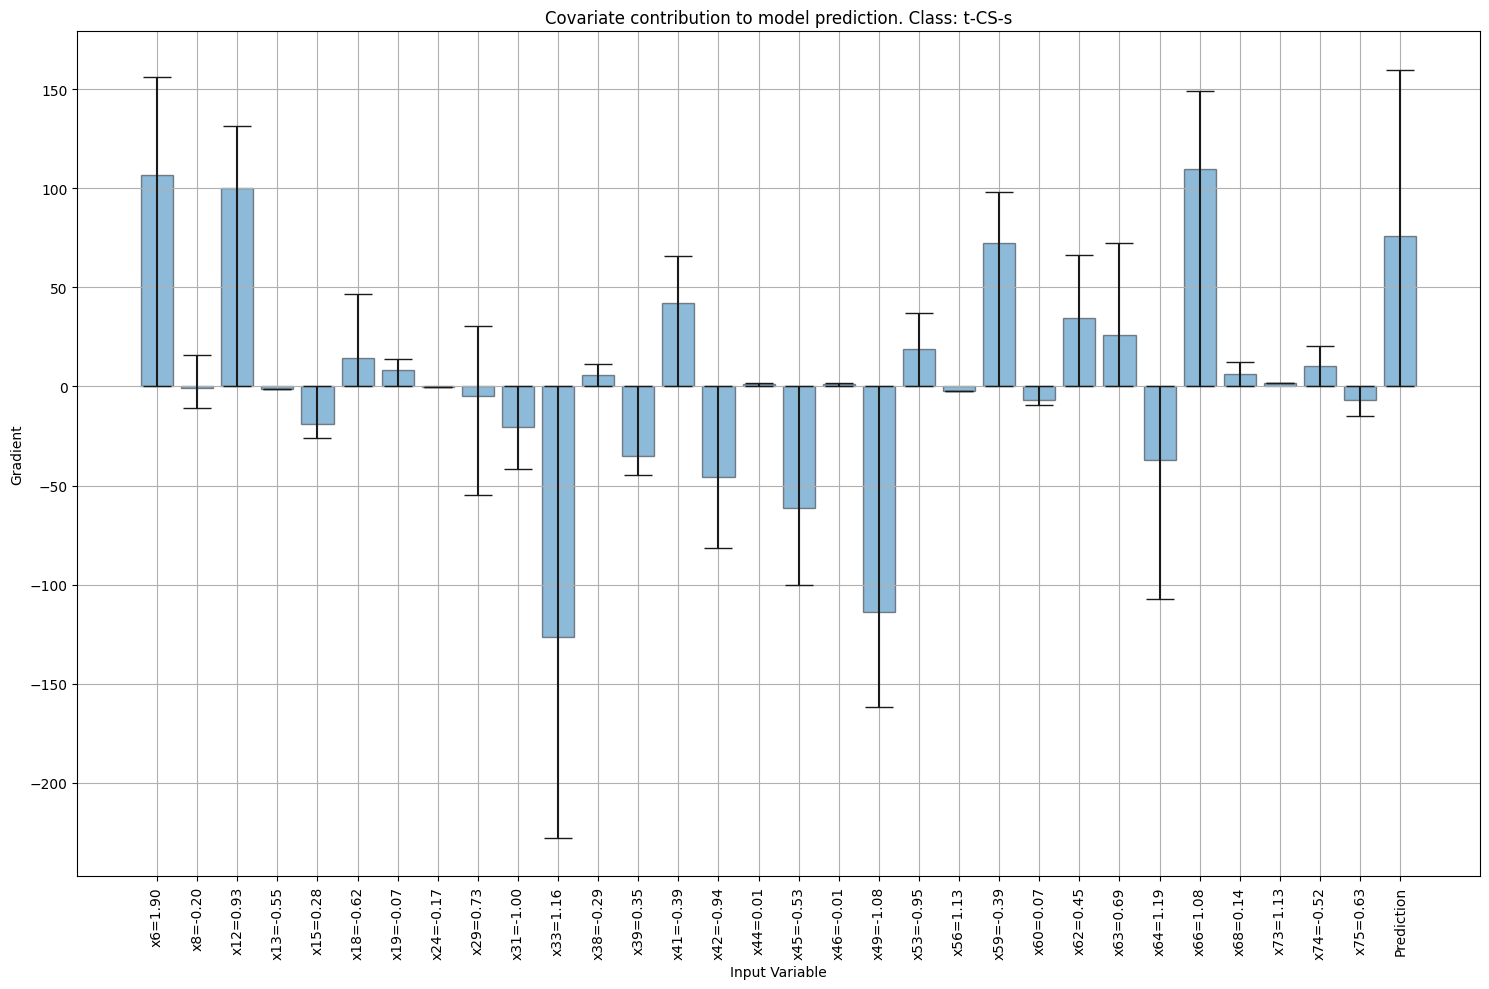

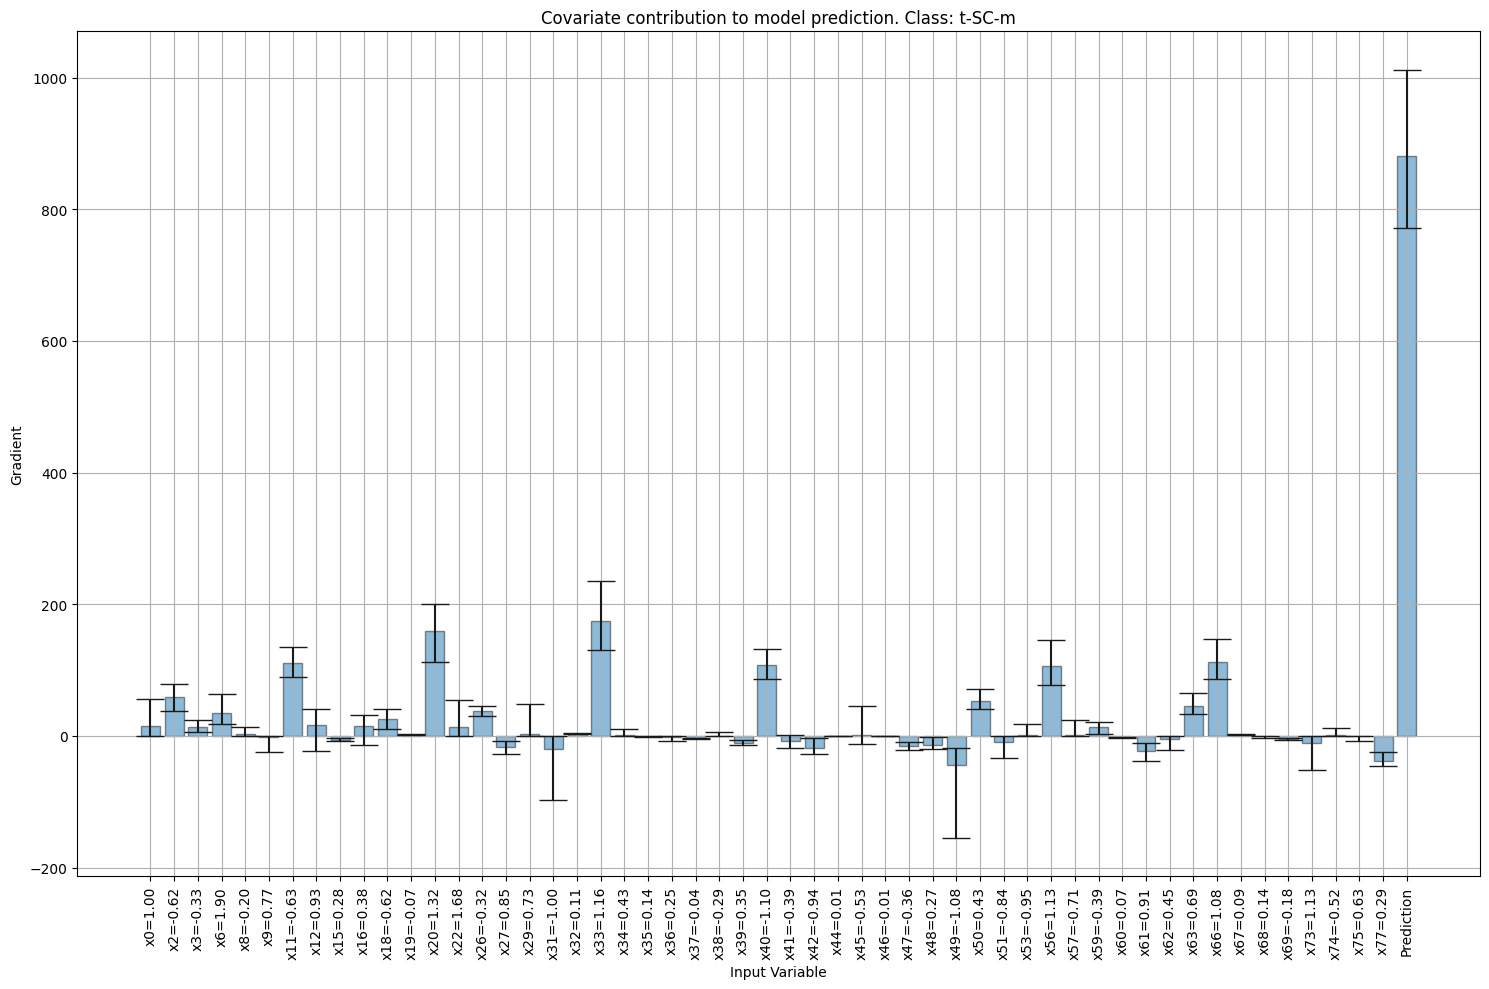

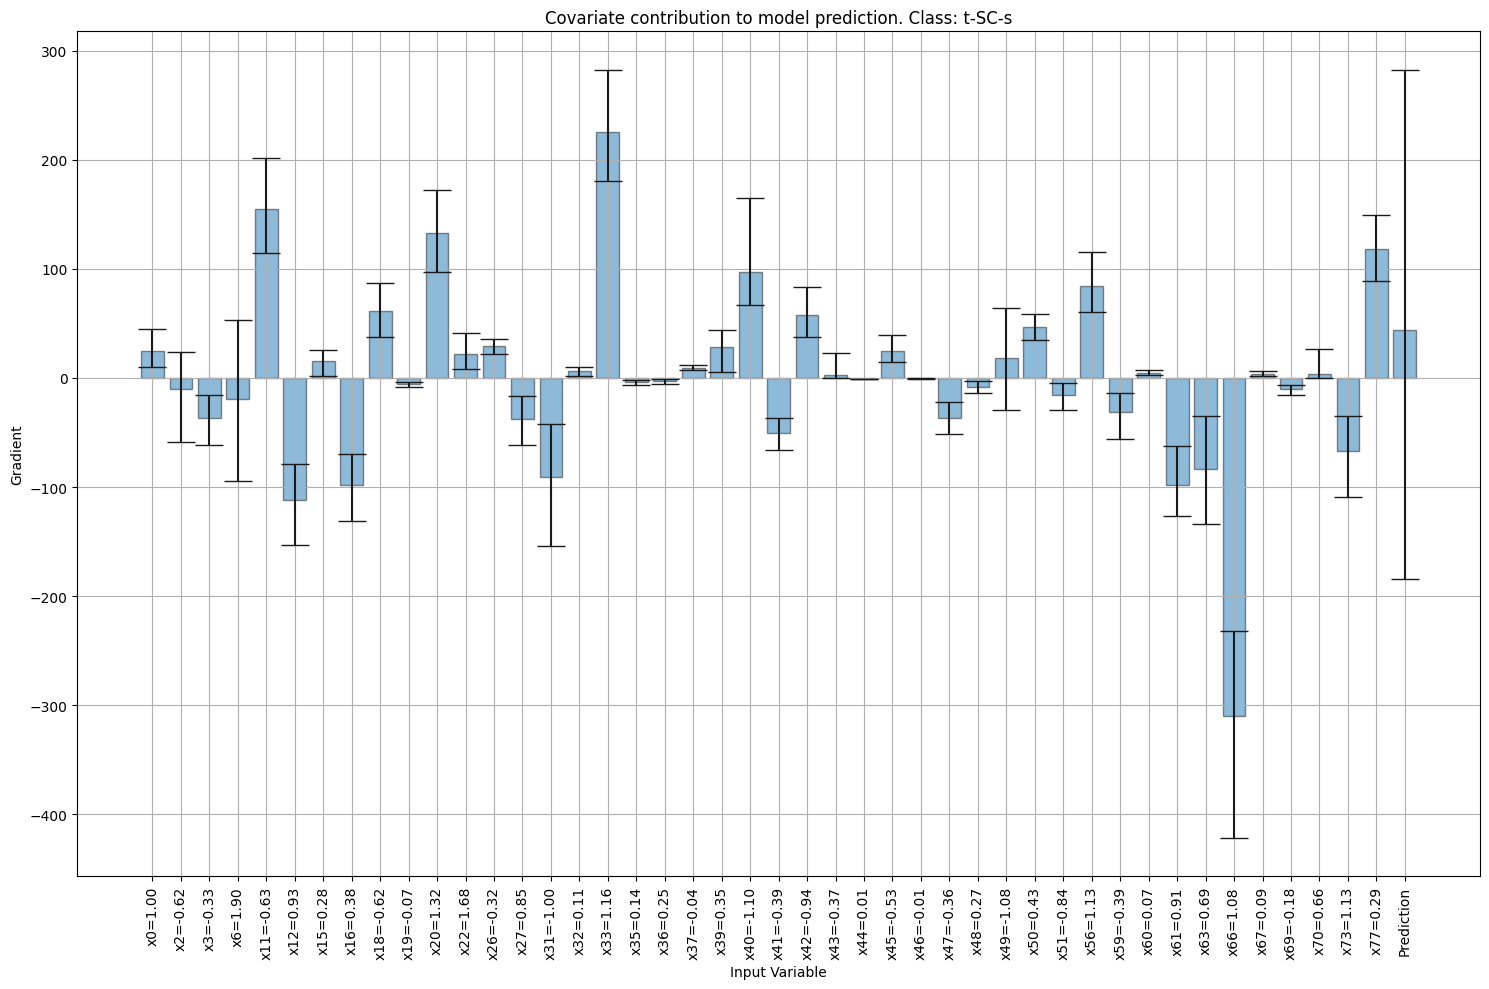

In [16]:
i = 15
explain_this = test_dat[i,:-1].reshape(-1, p)[0]
output_val = test_dat[i,-1]
print(f"True output value: {int(output_val)} --> {class_names[int(output_val)]}")
pf.plot_local_explain_piecewise_linear_act(
    net, 
    explain_this, 
    n_samples=100, 
    n_classes=n_classes,
    class_names=copy.deepcopy(class_names),
    magnitude=False, 
    include_prediction=True, 
    include_bias=True, 
    fig_size=(15,10), 
    no_zero_contributions=True, 
    include_potential_contribution=False,
    save_path=f"imgs/local_contribution_output_{output_val}_actual_contribution_class_")

True output value: 1 --> c-CS-s


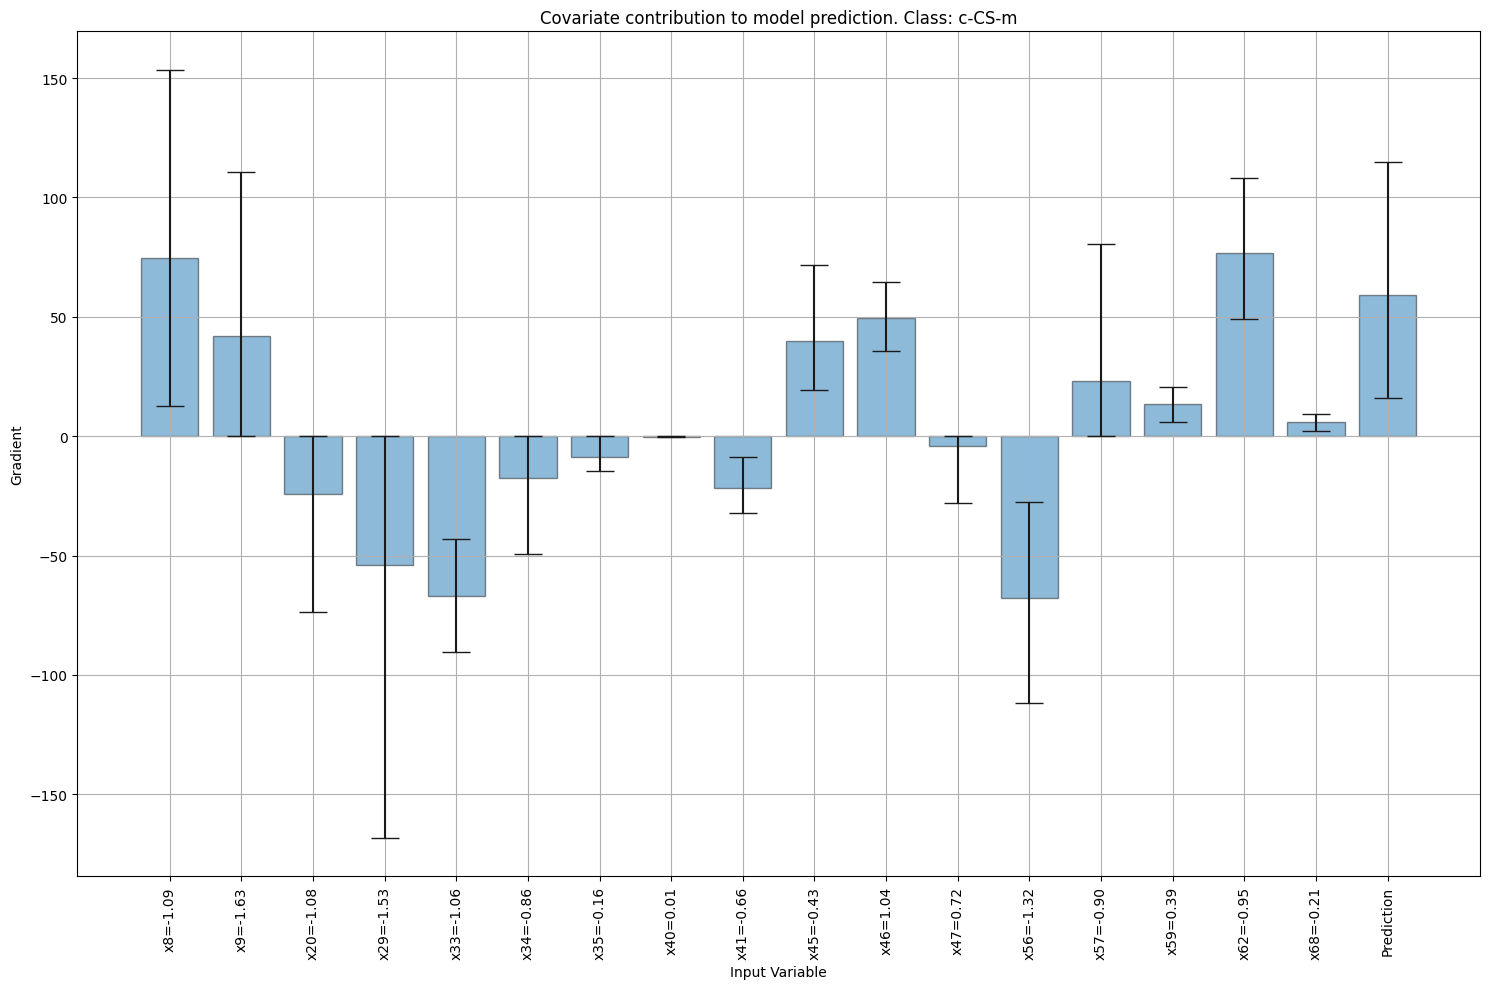

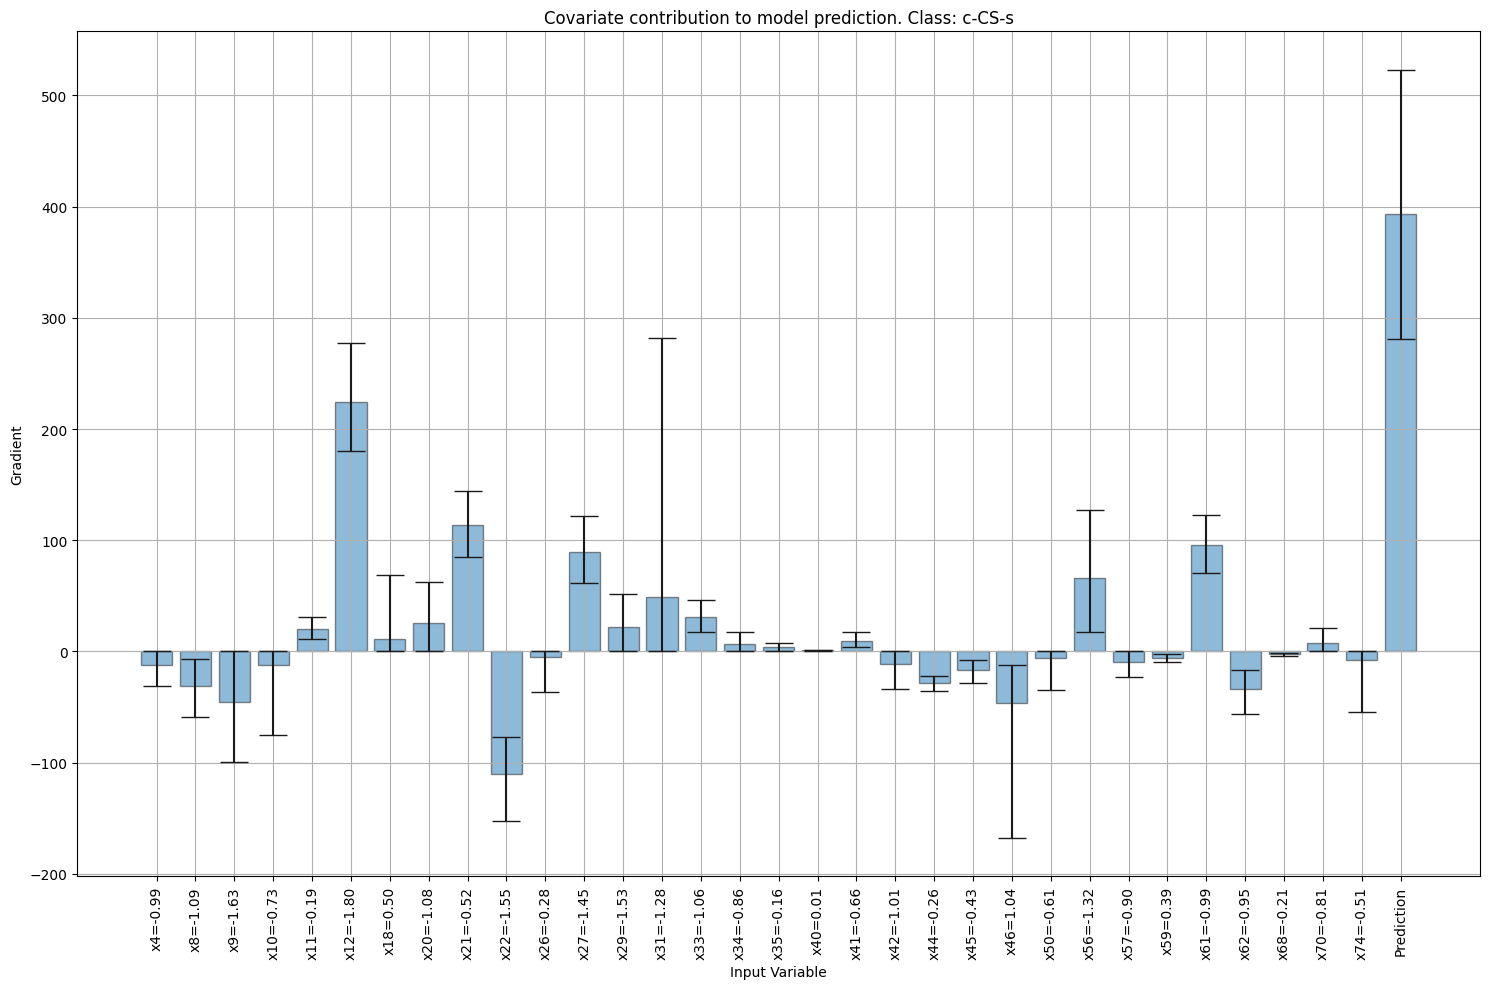

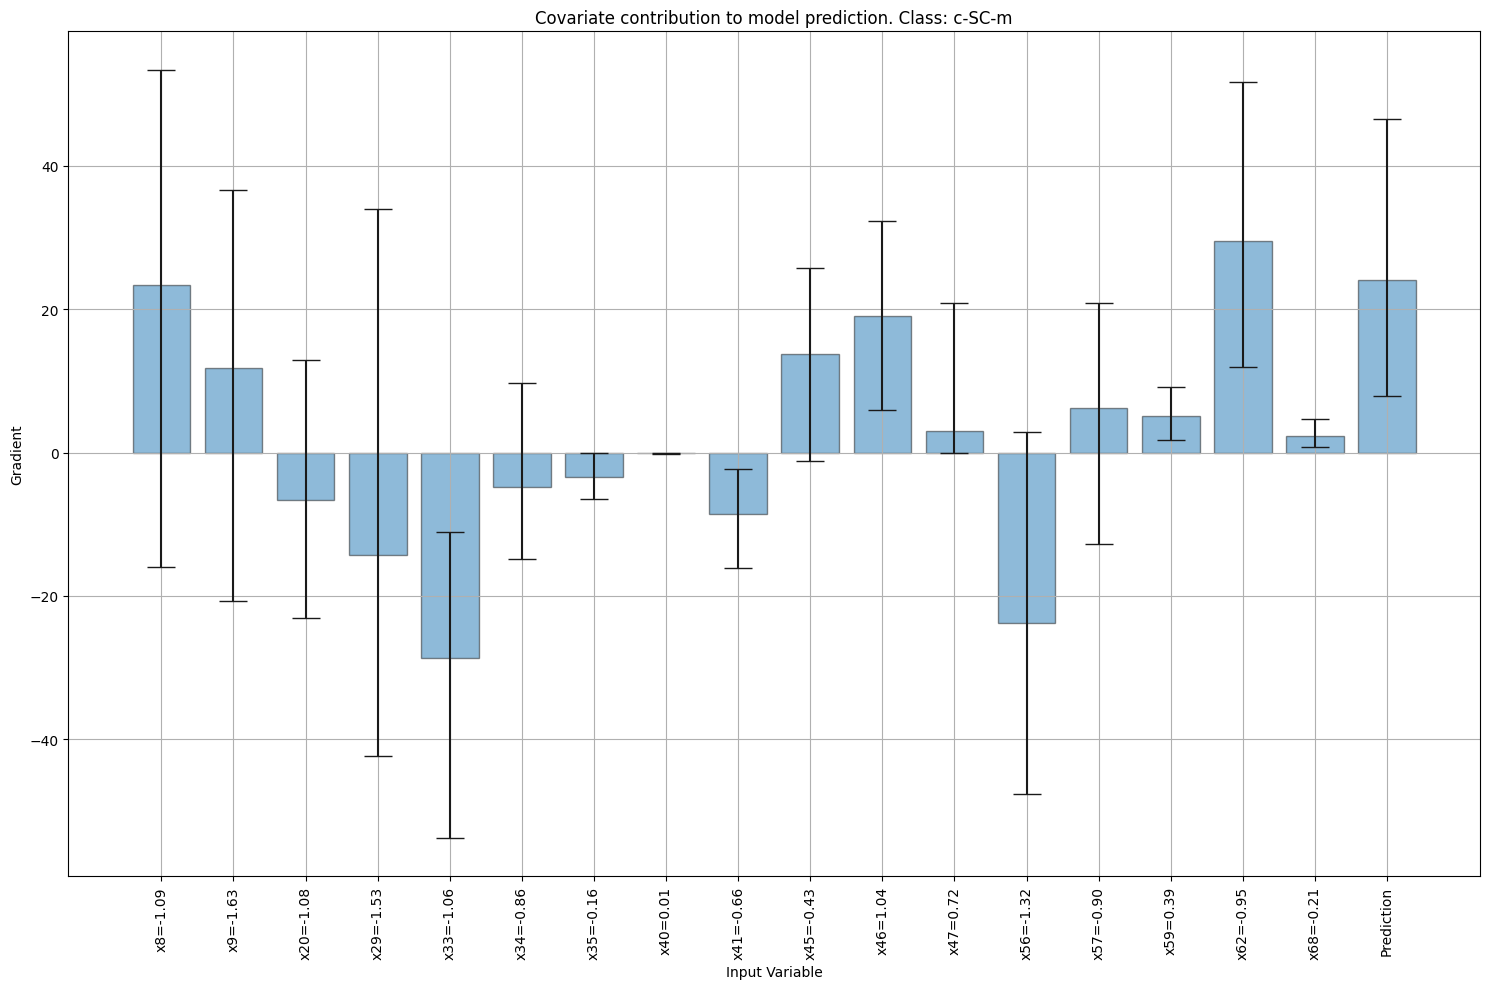

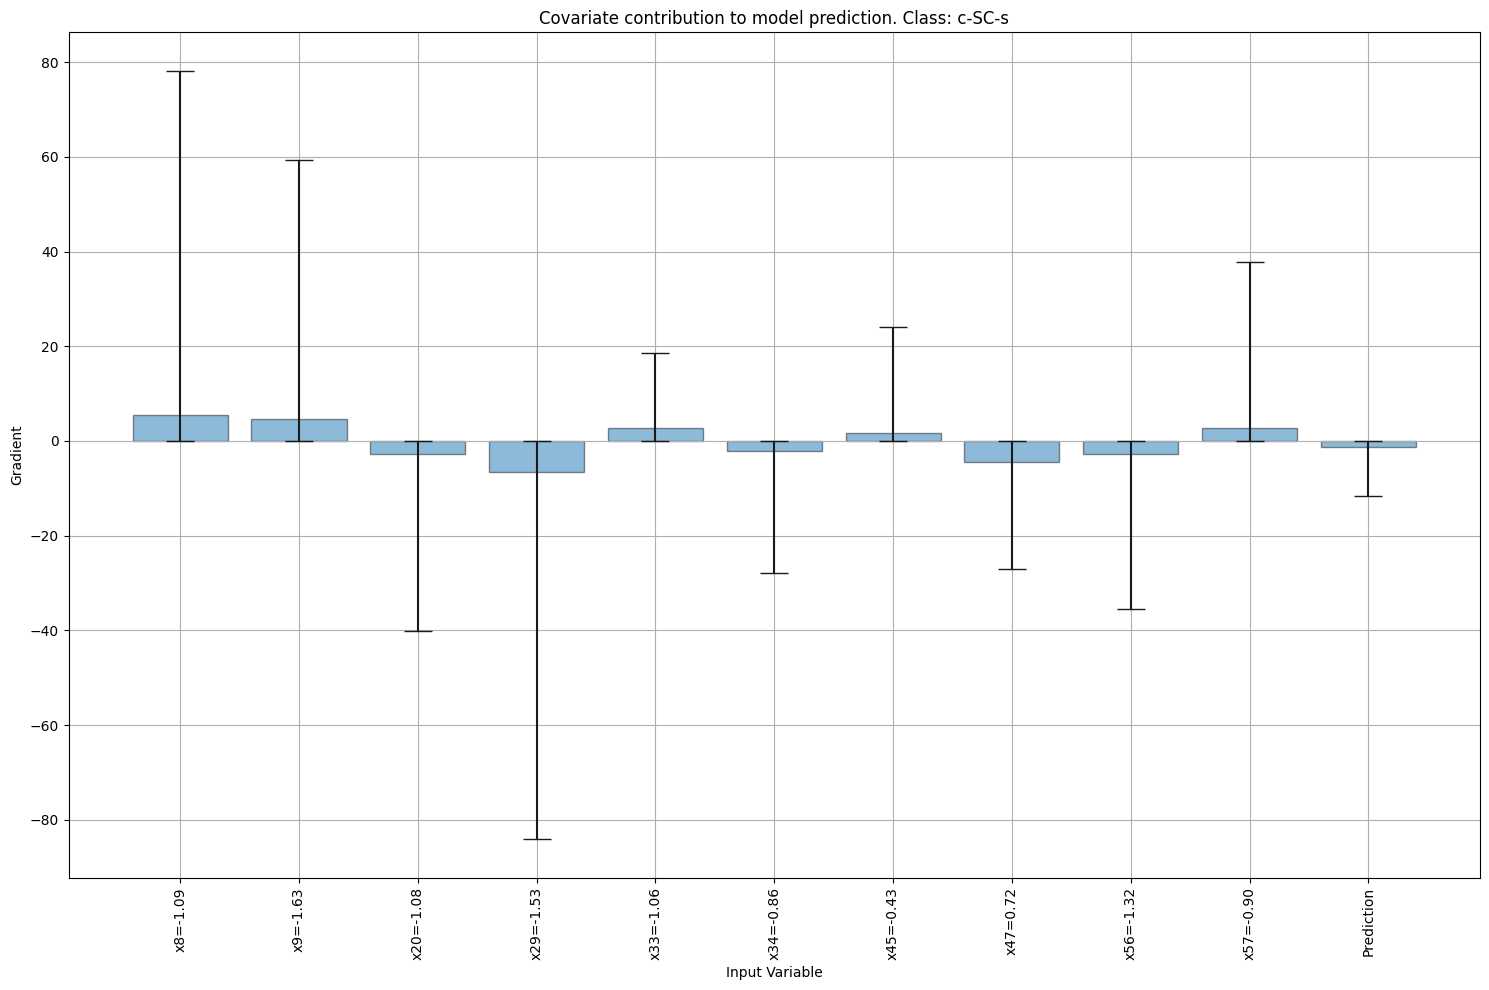

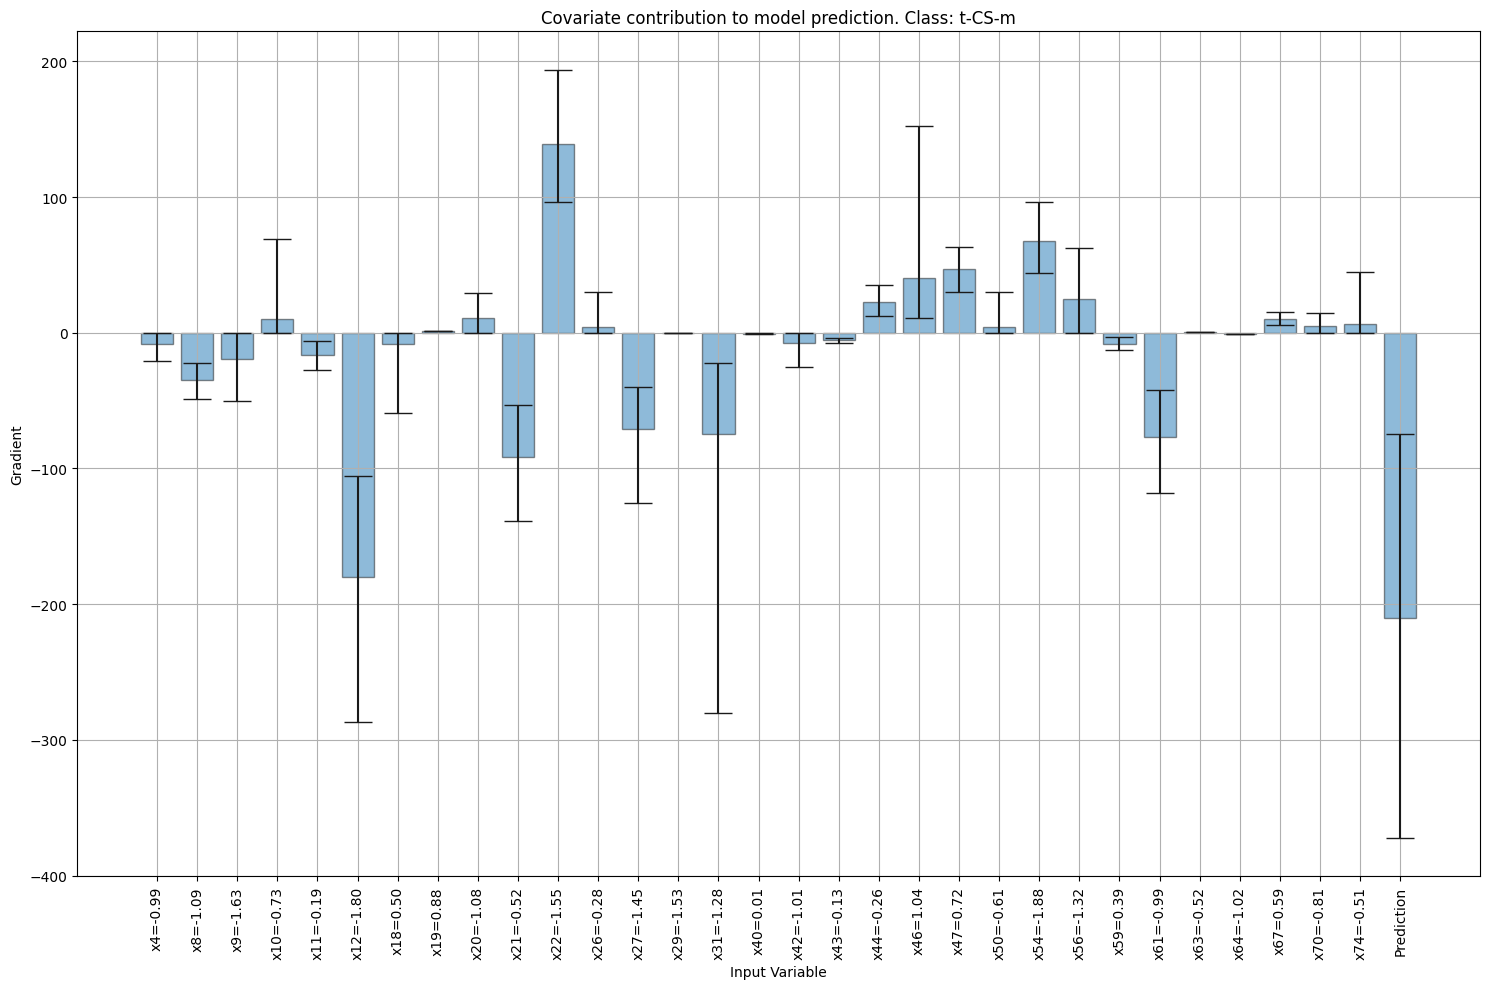

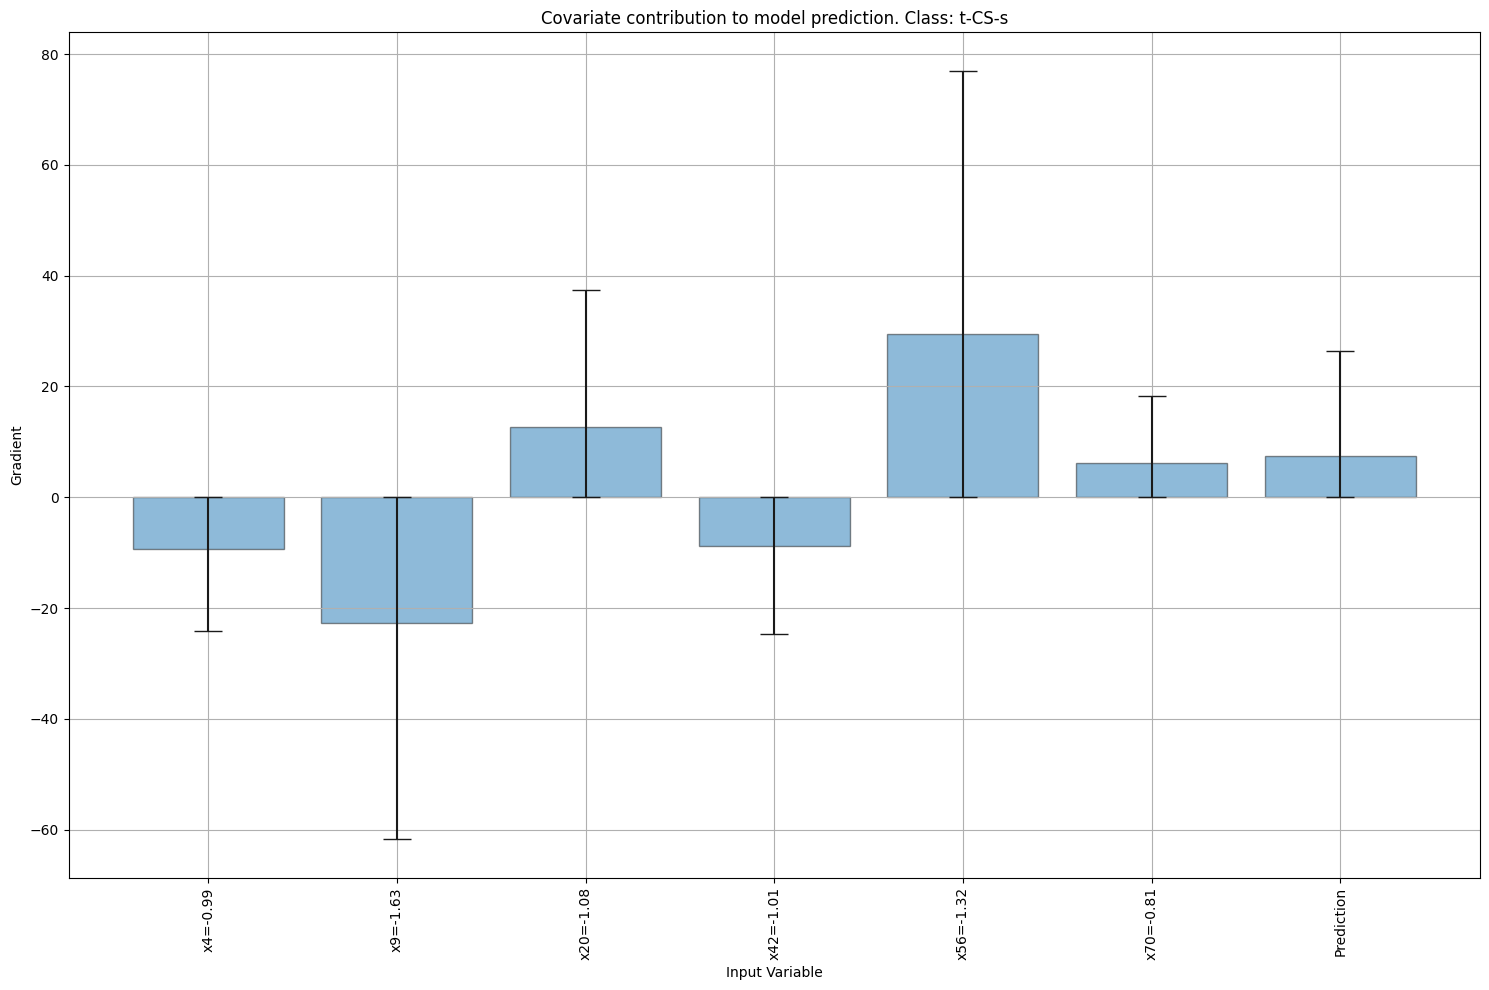

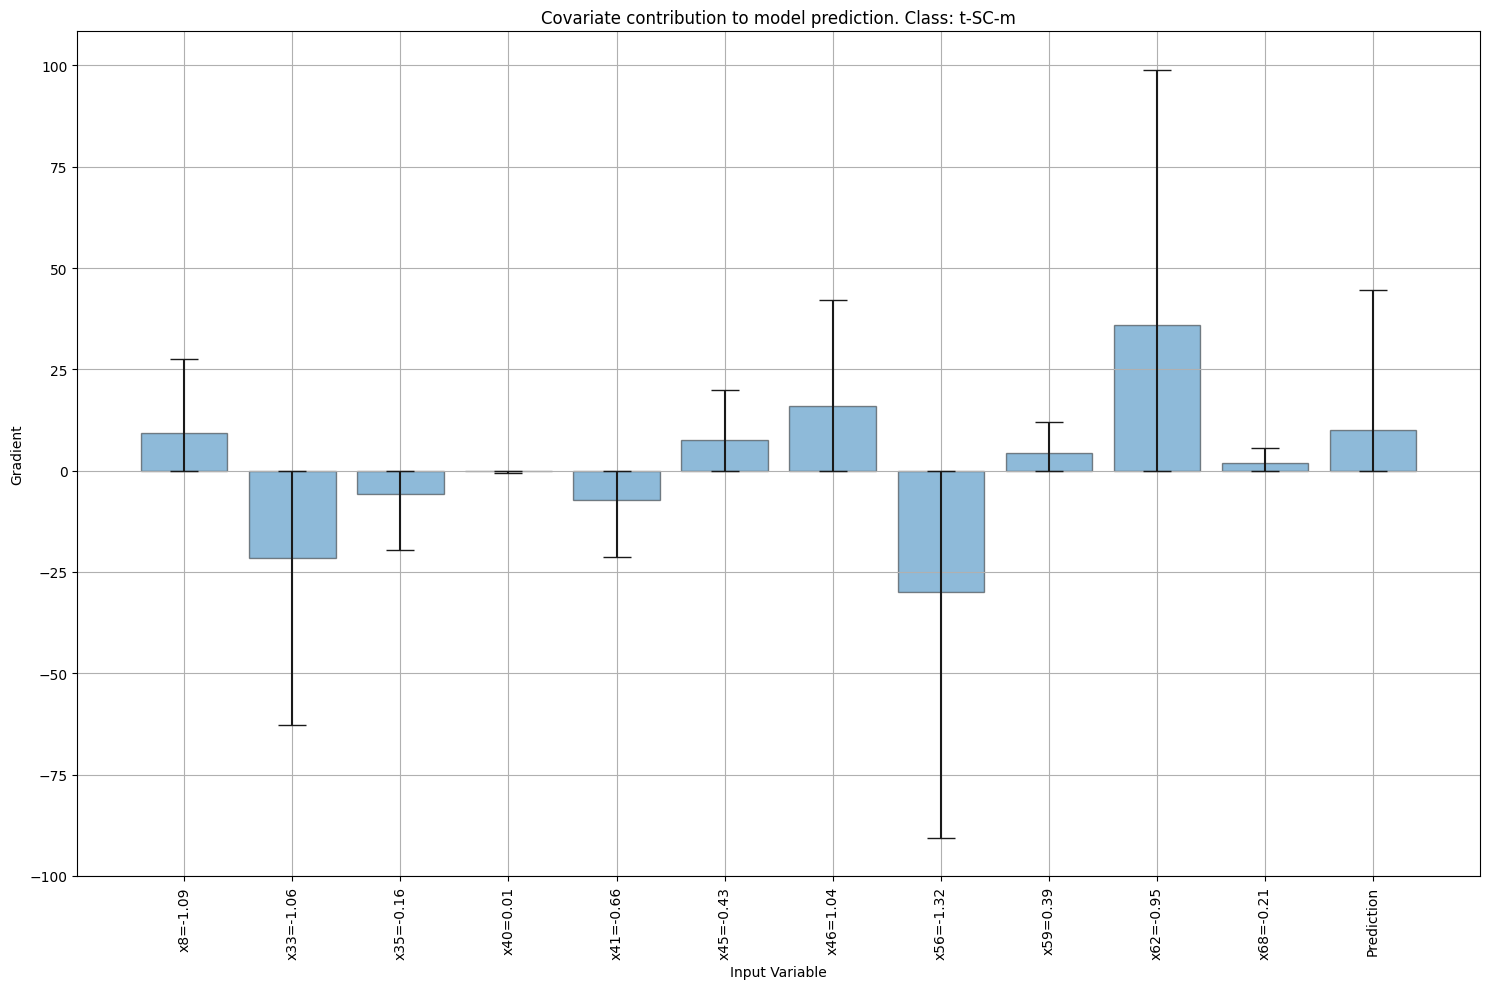

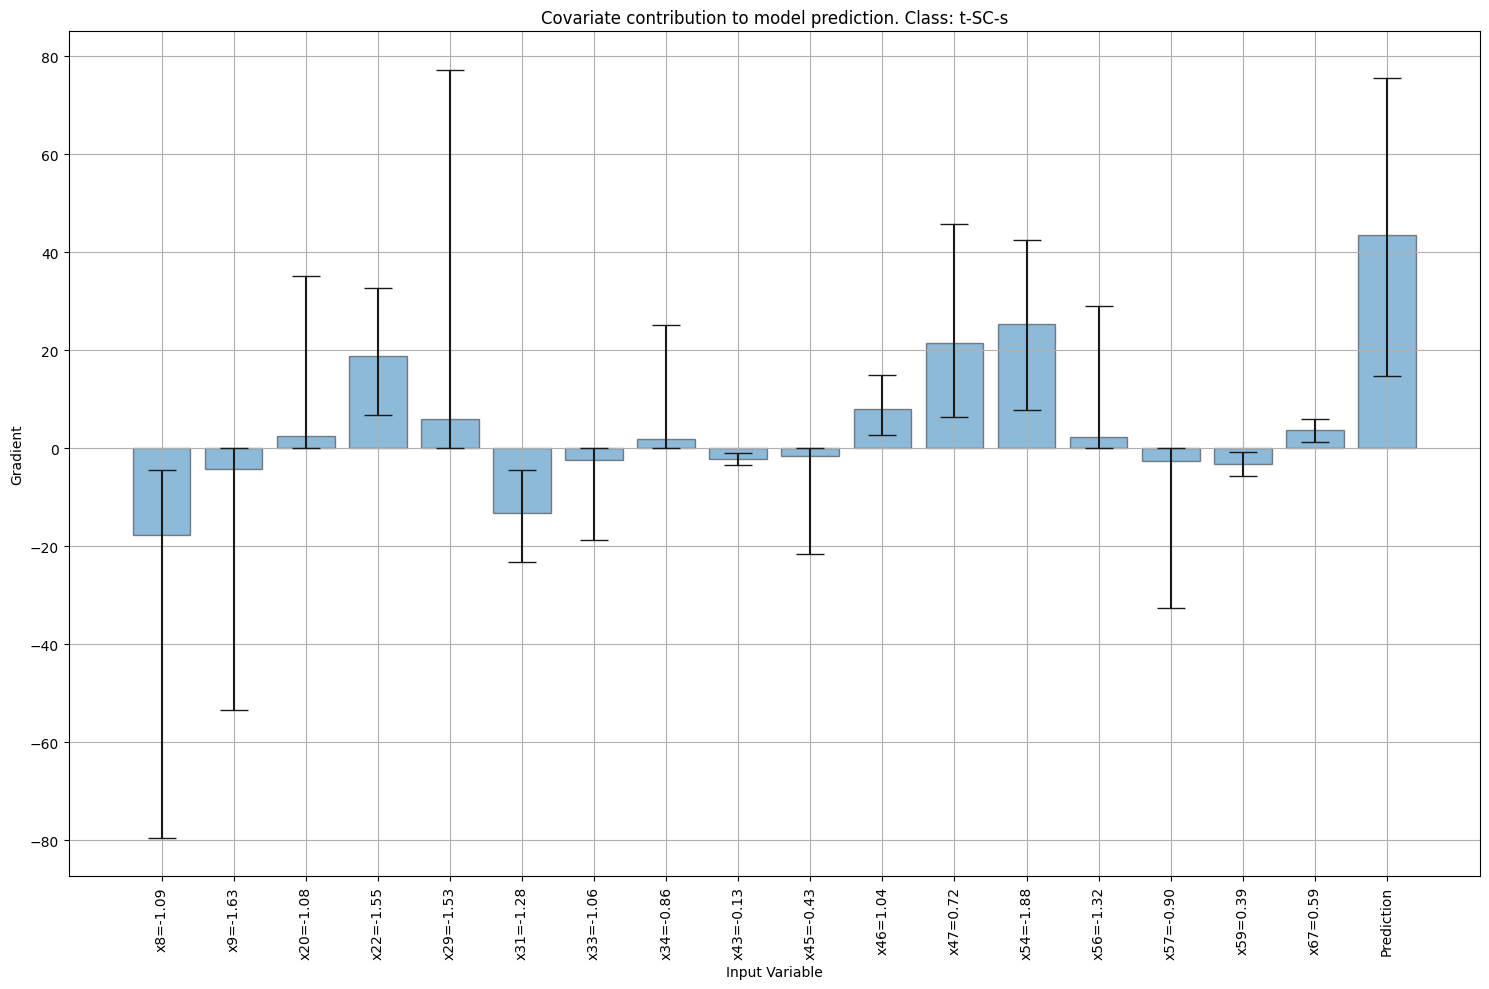

In [17]:
i = 10
explain_this = test_dat[i,:-1].reshape(-1, p)[0]
output_val = test_dat[i,-1]
print(f"True output value: {int(output_val)} --> {class_names[int(output_val)]}")
pf.plot_local_explain_piecewise_linear_act(
    net, 
    explain_this, 
    n_samples=100, 
    n_classes=n_classes,
    class_names=copy.deepcopy(class_names),
    magnitude=False, 
    include_prediction=True, 
    include_bias=True, 
    fig_size=(15,10), 
    no_zero_contributions=True, 
    include_potential_contribution=False,
    save_path=f"imgs/local_contribution_output_{output_val}_actual_contribution_class_")